In [154]:
%matplotlib inline
import sys, os, glob

from astropy.io import fits, ascii

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy import units as u
from astropy.table import Table
import astropy.constants as const
from astropy.coordinates import SkyCoord, concatenate
from astropy import table

from astropy.cosmology import FlatLambdaCDM, z_at_value
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

import scipy.stats as st
from scipy.optimize import minimize

from scipy.special import erf, gamma, gammainc
from scipy.integrate import trapezoid, cumulative_trapezoid

import emcee
import corner

In [155]:
import scienceplots

plt.style.use(['science', 'no-latex', 'notebook', 'light'])

In [156]:
def f_r(x, x0, f_a=1, delta=1, theta=2.5):
    
    focc = 1/(1 + delta * np.exp(-theta*(x - x0)))**(1/delta)
    
    return f_a * focc

In [157]:
def log_likelihood(theta, x, y, xerr, yerr, logLIR, logLIRerr, d25, n, p_obs):

    # parameters to be fit
    log_ms0, log_lam_min, delta1, log_f, f_a, delta, theta2 = theta

    x_bh = 7.43 + 1.61*(x - np.log10(3e10)) # 0.81
    BC = 3 # Bolometric correction
    log_lam = y + BC - 38.2 - x_bh # residual
    lam = 10**log_lam
    lam_min = 10**log_lam_min

    dlogl = .01
    log_lam_eval = np.arange(log_lam_min, 1, dlogl)
    lam_eval = 10**log_lam_eval
    dlam_eval = np.diff(lam_eval)
    dlam_int = dlam_eval

    mask_det = yerr > 0

    s2 = np.full(len(mask_det), np.exp(2*log_f)**2 + (xerr)**2)
    s2[mask_det] = yerr[mask_det]**2 + np.exp(2*log_f)**2 + (xerr[mask_det])**2

    if np.min(log_lam[mask_det]) < log_lam_min:
        return -np.inf

    q_TIR = 1.4
    b = 2*n - 1/3
    logL_SF = logLIR - q_TIR + np.log10(gammainc(2*n, b*(r_match.to(u.arcsec).value/(d25/2))**1/n)/gamma(2*n))

    # Either the source is an XRB or a BH
    s2_XRB = np.full(len(mask_det), (0.4)**2 + xerr**2)
    s2_XRB[mask_det] = (0.4)**2 + (yerr[mask_det])**2 + (xerr[mask_det])**2
    p_XRB = st.norm.sf(y - logL_SF, scale=np.sqrt(s2_XRB))

    # p = f * N + (1 - p) delta 
    _f_BHOF = f_r(x, log_ms0, f_a, delta, theta2)

    # pdf
    alpha = delta1 + 1 # must be > 1

    pdf_pl = (alpha-1) * lam_min**(alpha-1) * lam_eval**-alpha
    pdf_norm = st.norm.pdf(log_lam[mask_det, np.newaxis] - log_lam_eval, scale=np.sqrt(s2[mask_det, np.newaxis]))
    pdf = trapezoid(pdf_pl * pdf_norm, dx=dlam_eval, axis=1)

    # [data axis], convolve axis, int axis
    log_lam_int = log_lam_eval - np.max(log_lam_eval) + log_lam[~mask_det, np.newaxis]
    y_int = log_lam_int - BC + 38.2 + x_bh[~mask_det, np.newaxis]
    dlam_int = dlam_eval

    pdf_norm_int = st.norm.pdf(log_lam_eval[:, np.newaxis] - log_lam_eval, scale=np.sqrt(np.mean(s2[~mask_det])))
    pdf_int = trapezoid(pdf_pl * pdf_norm_int, dx=dlam_eval, axis=1)

    pdf_int[log_lam_eval < log_lam_min] = 0.0
    pdf_int_lam = np.array([np.interp(log_lam_int_i, log_lam_eval, pdf_int) for log_lam_int_i in log_lam_int])

    # data axis, int axis
    cdf = trapezoid((1 - st.norm.sf(y_int - logL_SF[~mask_det, np.newaxis], scale=np.sqrt(s2_XRB)[~mask_det, np.newaxis])) * pdf_int_lam, dx=dlam_int, axis=1)

    p_det = p_obs[mask_det] * (1 - p_XRB[mask_det]) * _f_BHOF[mask_det] * pdf # second term is zero for detected sources
    p_cens = p_obs[~mask_det] * (_f_BHOF[~mask_det] * cdf + (1 - _f_BHOF[~mask_det]))

    # Total likelihood
    ll = np.sum(np.log(p_det)) + np.sum(np.log(p_cens))

    return ll

In [158]:
def log_prior(theta):
    logms0, log_lam_min, delta1, log_f, f_a, delta, theta2 = theta

    # Power-Law Priors
    if 5.0 < logms0 < 12.0 and -10 < log_lam_min < 0 and 0.01 < delta1 < 2.0 and -2.0 < log_f < 1.0 and 0 < f_a < 1 and 0.01 < delta < 50 and 0.01 < theta2 < 50:
        return 0.0
        
    return -np.inf

In [159]:
hdul = fits.open('catalog.fits')
data_50Mpc = Table(hdul[1].data)
#print(data.names)

cat_50Mpc = SkyCoord(data_50Mpc['ra'], data_50Mpc['dec'], unit='deg')

###########################
r_match = 1.0*u.arcsec ####
###########################

In [160]:
data_50Mpc

objname,pgc,nsaid,group_id,ra,dec,ra_nsa,dec_nsa,ra_ned,dec_ned,d25,v_h,v_cmb,v_source,hl_obj,lvg_obj,nsa_obj,sga_obj,t_type,color_type,best_type,a_B_leda,a_g_nsa,EBV_irsa,Bt0_leda,BV_color_leda,B_lum,gi_color_nsa,i_lum_nsa,gr_color_sga,r_lum_sga,BR_color_ned,R_lum_ned,BMag,gi_color,mag_flag,cf3_dist,cf3_dist_error,zind_dist,zind_dist_error,zind_indicator,bestdist,bestdist_error,bestdist_method,bestdist_source,dist_ned_flag,logmass_gi,logmass_gr,logmass_BV,logmass_BR,logmass,logmass_error,logmass_src,chandra_observation,chandra_detection,log_lx,chandra_detection_3arcsec,log_lx_3arcsec
str29,int32,int32,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,str3,float64,float64,float64,float64,float64,str6,str6,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str32,float64,float64,str32,int32,int32,float64,float64,float64,float64,float64,float64,str64,float64,float64,float64,float64,float64
2MASXJ01235631+0012308,3519080,114636,-1,20.984826,0.2084866,20.98477715,0.208338,20.98476,0.2085,0.4518559443749224,2396.68,2119.25,nsa,1.0,0.0,1.0,1.0,10.0,late,late,0.11352000000000001,0.09954,0.0262,16.961000000000002,nan,283903588.9420711,0.6306607471205918,253763377.28857803,0.4531887057861326,224319819.9721301,nan,nan,-15.69292720663945,0.6306607471205918,0.0,32.21672880740414,5.506498211637053,nan,nan,nan,32.217,5.506,CF3-Z,3,-1,8.166,8.234,nan,nan,8.166,0.15,g-i,0.0,0.0,nan,0.0,nan
2MASXJ04575930-0612323,3689848,-1,-1,74.4971145,-6.2089139,nan,nan,74.49712,-6.20889,nan,3012.0,3123.92,hyp,1.0,0.0,0.0,0.0,9.0,notype,late,0.19436,nan,0.0452,15.059,nan,2436816317.289007,nan,nan,nan,nan,nan,nan,-18.02705698525738,nan,nan,37.873844962917495,5.2713110095085085,nan,nan,nan,37.874,5.271,CF3-Z,3,-1,nan,nan,nan,nan,nan,nan,,0.0,0.0,nan,0.0,nan
2MASXJ05534289-3205449,3704923,-1,-1,88.4288985,-32.0958874,nan,nan,88.42883,-32.09581,nan,2878.9,2858.64,hyp,1.0,0.0,0.0,0.0,9.0,notype,late,0.1419,nan,0.0328,16.191,nan,993914223.7061572,nan,nan,nan,nan,nan,nan,-17.05337226436726,nan,nan,41.734426780524835,5.581341249003874,nan,nan,nan,41.734,5.581,CF3-Z,3,-1,nan,nan,nan,nan,nan,nan,,0.0,0.0,nan,0.0,nan
2MASXJ06094464-3250007,3707868,-1,-1,92.436063,-32.8336302,nan,nan,92.43604,-32.83361,nan,1417.7,1267.35,hyp,1.0,0.0,0.0,0.0,-3.0,notype,early,0.19436,nan,0.0447,15.363,nan,496387057.0462711,nan,nan,nan,nan,nan,nan,-16.299551122605276,nan,nan,19.662476859710292,6.8871789758103,nan,nan,nan,19.662,6.887,CF3-Z,3,-1,nan,nan,nan,nan,nan,nan,,0.0,0.0,nan,0.0,nan
2MASXJ07415401+2352188,3723606,-1,-1,115.475523,23.8717641,nan,nan,115.47567,23.87175,0.5780960474057181,2269.3,1979.61,hyp,1.0,0.0,0.0,1.0,10.0,late,late,0.17114000000000001,nan,0.0395,15.972999999999999,nan,708288321.6268822,nan,nan,0.5239617447509772,547283615.0458648,nan,nan,-16.68552520284831,0.7377042218932411,nan,31.4396020713284,6.821081567051401,nan,nan,nan,31.44,6.821,CF3-Z,3,-1,nan,8.707,nan,nan,8.707,0.191,g-r,0.0,0.0,nan,0.0,nan
2MASXJ08241658+2710571,3729986,-1,-1,126.069153,27.182415,nan,nan,126.06919,27.18244,0.17298163592151014,962.9,1064.77,hyp,1.0,0.0,0.0,0.0,nan,notype,notype,0.14018,nan,0.0323,18.73,nan,13584592.284595454,nan,nan,nan,nan,nan,nan,-12.392616521090229,nan,nan,15.721258336507505,5.024527127250969,nan,nan,nan,15.721,5.025,CF3-Z,3,-1,nan,nan,nan,nan,nan,nan,,0.0,0.0,nan,0.0,nan
2MASXJ09343407+1300201,3743904,532859,-1,143.642133,13.005688,143.64209443,13.00565104,143.64224,13.00574,nan,3052.56,3407.63,nsa,1.0,0.0,1.0,0.0,-2.4,notype,early,0.1118,0.0995,0.0258,16.569,nan,867293117.4852496,nan,nan,nan,nan,nan,nan,-16.905414750012355,nan,0.0,47.046026622834326,4.9279757630117516,nan,nan,nan,47.046,4.928,CF3-Z,3,-1,nan,nan,nan,nan,nan,nan,,0.0,0.0,nan,0.0,nan
2MASXJ09370295+6609161,3744472,403868,-1,144.262287,66.154824,144.26234289,66.15486662,144.26235,66.15494,nan,3384.45,3262.89,nsa,1.0,0.0,1.0,0.0,5.6,late,late,0.75766,0.67688,0.1755,15.818,nan,

## Match to SDSS for updated redshifts

In [161]:
#J/MNRAS/474/3875/gamadr3

In [162]:
from astroquery.vizier import Vizier
from astroquery.simbad import Simbad
Vizier.ROW_LIMIT = -1
Simbad.TIMEOUT = 400 # seconds

result_table = Vizier(catalog="V/154/sdss16", timeout=400).query_region(cat_50Mpc, radius=r_match)
result_table[0]

_q,objID,RA_ICRS,DE_ICRS,mode,class,clean,e_RA_ICRS,e_DE_ICRS,umag,gmag,rmag,imag,zmag,e_umag,e_gmag,e_rmag,e_imag,e_zmag,zsp,e_zsp,f_zsp,zph,e_zph,__zph_,Q,SDSS16,Sp-ID,_tab1_130
,,deg,deg,,,,arcsec,arcsec,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,,,,,,,,,,d
int32,int64,float64,float64,uint8,uint8,uint8,float64,float64,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,int16,float32,float32,float32,uint8,str24,str16,float64
1,1237646011629174917,20.984799,0.208487,3,3,0,0.019,0.035,17.780,16.842,16.456,16.269,16.107,0.019,0.005,0.005,0.005,0.017,--,--,--,--,--,--,3,SDSS J012356.35+001230.5,,51081.3415
1,1237646011629174918,20.984798,0.208487,2,3,0,0.019,0.035,17.836,16.852,16.465,16.287,16.122,0.020,0.005,0.005,0.005,0.017,--,--,--,--,--,--,3,SDSS J012356.35+001230.5,,51081.3415
1,1237646505539600533,20.984801,0.208487,3,3,0,0.017,0.046,17.868,16.852,16.431,16.250,16.118,0.018,0.004,0.005,0.006,0.021,--,--,--,--,--,--,3,SDSS J012356.35+001230.5,,51132.2024
1,1237646505539600534,20.984787,0.208482,3,3,0,0.017,0.045,17.878,16.873,16.447,16.282,16.148,0.017,0.005,0.005,0.006,0.021,--,--,--,--,--,--,3,SDSS J012356.34+001230.5,,51132.2024
1,1237646505539600535,20.984787,0.208482,4,3,0,0.017,0.045,17.878,16.873,16.447,16.282,16.148,0.017,0.005,0.005,0.006,0.021,--,--,--,--,--,--,3,SDSS J012356.34+001230.5,,51132.2024
1,1237646647275159646,20.984780,0.208492,2,3,0,0.018,0.060,17.873,16.897,16.502,16.229,16.259,0.017,0.004,0.005,0.006,0.020,--,--,--,--,--,--,3,SDSS J012356.34+001230.5,,51136.1918
1,1237656512815825014,20.984787,0.208457,3,3,0,0.020,0.066,17.884,16.884,16.486,16.278,16.088,0.026,0.005,0.006,0.033,0.023,--,--,--,--,--,--,3,SDSS J012356.34+001230.4,,52170.3789
1,1237656512815825015,20.984775,0.208460,3,3,0,0.020,0.068,17.845,16.891,16.491,16.282,16.132,0.020,0.005,0.006,0.033,0.021,--,--,--,--,--,--,3,SDSS J012356.34+001230.4,,52170.3789


In [163]:
# Remove sources with redshift > 0.12 (~51 Mpc)

mask_zsp = np.isfinite(result_table[0]['zsp'].data.data)
cat_result = SkyCoord(result_table[0]['RA_ICRS'][mask_zsp], result_table[0]['DE_ICRS'][mask_zsp])
idx_result, idx_50Mpc, d2d, d3d = cat_50Mpc.search_around_sky(cat_result, 0.5*u.arcsec)

data_50Mpc['z_dr16'] = -1.0 # mJy
data_50Mpc['z_dr16'][idx_50Mpc] = result_table[0]['zsp'].data.data[mask_zsp][idx_result]

## Match to GAMA

In [164]:
result_table = Vizier(catalog="J/MNRAS/474/3875/gamadr3", timeout=400).query_region(cat_50Mpc, radius=0.5*u.arcsec)
result_table[0]

_q,spectID,Survey,RAJ2000,DEJ2000,z,NQ,Prob,URL,URLimg,CataId,GAMA,Dist
,,,deg,deg,,,,,,,,arcsec
int32,str33,str9,float64,float64,float64,uint8,float32,str88,str92,int32,str23,float32
2560,6dFg0214095-064823,6dFGS,33.53942,-6.80633,0.00715,3,0.000,http://www.gama-survey.org/dr3/data/spectra/6dfgs/g0214095-064823.fit,http://www.gama-survey.org/dr3/data/spectra/6dfgs/png/g0214095-064823.png,2138298,GAMAJ021409.47-064822.6,0.29
2615,320975784472766464,SDSS,178.55114,0.13659,0.00378,2,0.000,http://www.gama-survey.org/dr3/data/spectra/sdss/spec-0285-51663-0343.fit,http://www.gama-survey.org/dr3/data/spectra/sdss/png/spec-0285-51663-0343.png,70114,GAMAJ115412.26+000811.8,0.15
2615,320977163341817856,SDSS,178.55114,0.13659,0.00379,2,0.000,http://www.gama-survey.org/dr3/data/spectra/sdss/spec-0285-51930-0348.fit,http://www.gama-survey.org/dr3/data/spectra/sdss/png/spec-0285-51930-0348.png,70114,GAMAJ115412.26+000811.8,0.15
2615,2dF298044,2dFGRS,178.55126,0.13661,0.00380,4,0.000,http://www.gama-survey.org/dr3/data/spectra/2dfgrs/298044.fit,http://www.gama-survey.org/dr3/data/spectra/2dfgrs/png/298044.png,70114,GAMAJ115412.26+000811.8,0.49
2645,340044064088942592,SDSS,212.18034,-1.16165,0.00415,5,0.000,http://www.gama-survey.org/dr3/data/spectra/sdss/spec-0302-51616-0081.fit,http://www.gama-survey.org/dr3/data/spectra/sdss/png/spec-0302-51616-0081.png,496943,GAMAJ140843.28-010941.8,0.14
2645,340044889930622976,SDSS,212.18034,-1.16165,0.00415,2,0.000,http://www.gama-survey.org/dr3/data/spectra/sdss/spec-0302-51688-0084.fit,http://www.gama-survey.org/dr3/data/spectra/sdss/png/spec-0302-51688-0084.png,496943,GAMAJ140843.28-010941.8,0.14
2645,1031416713540823040,SDSS,212.18039,-1.16161,0.00415,5,0.000,http://www.gama-survey.org/dr3/data/spectra/sdss/spec-0916-52378-0336.fit,http://www.gama-survey.org/dr3/data/spectra/sdss/png/spec-0916-52378-0336.png,496943,GAMAJ140843.28-010941.8,0.10
3439,749860644005636096,SDSS,31.14511,-10.10847,0.00640,5,0.000,http://www.gama-survey.org/dr3/data/spectra/sdss/spec-0666-52149-0041.fit,http://www.gama-survey.org/dr3/data/spectra/sdss/png/spec-0666-52149-0041.png,2255550,GAMAJ020434.83-100630.1,0.37


In [165]:
# Remove sources with redshift > 0.12 (~51 Mpc)

mask_zsp = np.isfinite(result_table[0]['z'].data.data) & (result_table[0]['Prob'] > 0.0)
cat_result = SkyCoord(result_table[0]['RAJ2000'][mask_zsp], result_table[0]['DEJ2000'][mask_zsp])
idx_result, idx_50Mpc, d2d, d3d = cat_50Mpc.search_around_sky(cat_result, 0.5*u.arcsec)

data_50Mpc['z_gama'] = -1.0 # mJy
data_50Mpc['z_gama'][idx_50Mpc] = result_table[0]['z'].data.data[mask_zsp][idx_result]

### WISE

In [166]:

result_table = Vizier(catalog="II/328/allwise", timeout=3200).query_region(cat_50Mpc, radius=1.5*u.arcsec)
result_table[0]

# https://wise2.ipac.caltech.edu/docs/release/allsky/expsup/sec4_4h.html

cat_result = SkyCoord(result_table[0]['RAJ2000'], result_table[0]['DEJ2000'])
idx_result, idx_50Mpc, d2d, d3d = cat_50Mpc.search_around_sky(cat_result, 5*u.arcsec)

data_50Mpc['W4mag'] = -1.0 # 22 um
data_50Mpc['W4mag'][idx_50Mpc] = result_table[0]['W4mag'][idx_result]
data_50Mpc['e_W4mag'] = -1.0 # 22 um
data_50Mpc['e_W4mag'][idx_50Mpc] = result_table[0]['e_W4mag'][idx_result]

In [167]:
data_50Mpc['logSFR'] = 0.873*data_50Mpc['logmass']-8.99 # https://iopscience.iop.org/article/10.3847/1538-4357/aa9790/pdf

## Match to VLASS source catalog

In [168]:
from astroquery.vizier import Vizier
Vizier.ROW_LIMIT = -1

# the flux density measurements are likely underestimated by an average of ~15%.
# Additionally the astrometry is typically only accurate to ~0.25"

result_table = Vizier(catalog="J/ApJS/255/30").query_region(cat_50Mpc, radius=5*u.arcsec)
result_table[0]

_q,CompName,CompId,RAJ2000,DEJ2000,Ftot,e_Ftot,Fpeak,e_Fpeak,Islrms,SCode,DCMaj,DCMin,DCPA,Subtile,NVSSdist,FIRSTdist,PeakToRing,DupFlag,QualFlag,NNdist,MainSample,QLcutout
,,,deg,deg,mJy,mJy,mJy / beam,mJy / beam,mJy / beam,,arcsec,arcsec,deg,,arcsec,arcsec,,,,arcsec,,
int32,str31,int16,float64,float64,float64,float32,float64,float32,float32,str1,float64,float64,float64,str14,float64,float64,float64,uint8,uint8,float64,uint8,str237
141,VLASS1QLCIR J034227.81-260242.1,58,55.61589526,-26.04504514,20.790,0.237,17.376,0.119,0.118,S,0.0000,0.0000,0.0000,J034428-263000,2.15587,65364.28105,38.3879,0,0,223.41000,1,https://ws.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/caom2ops/sync?ID=ad%3AVLASS%2FVLASS1.1.ql.T04t06.J034428-263000.10.2048.v1.I.iter1.image.pbcor.tt0.subim.fits&RUNID%3Dmts17nwzt3fm0gs3&CIRCLE=55.61589525764924+-26.04504513891315+0.025
149,VLASS1QLCIR J042119.40-313803.8,25,65.33085795,-31.63440925,7.522,0.301,5.804,0.143,0.140,S,1.5667,0.8329,10.4173,J042059-313000,1.19014,90338.72228,12.6292,0,0,119.42000,1,https://ws.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/caom2ops/sync?ID=ad%3AVLASS%2FVLASS1.2.ql.T03t07.J042059-313000.10.2048.v1.I.iter1.image.pbcor.tt0.subim.fits&RUNID%3Dtoqjqfxjg5zix704&CIRCLE=65.33085795299331+-31.63440925291232+0.025
209,VLASS1QLCIR J113858.91-380041.7,20,174.74548204,-38.01158462,5.810,0.205,5.610,0.107,0.117,S,0.0000,0.0000,0.0000,J113730-373000,2.03022,107678.95046,7.8130,2,0,--,0,https://ws.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/caom2ops/sync?ID=ad%3AVLASS%2FVLASS1.1.ql.T01t24.J113730-373000.10.2048.v1.I.iter1.image.pbcor.tt0.subim.fits&RUNID%3Dxpoy2fevt8o4n95n&CIRCLE=174.7454820365871+-38.01158461806799+0.025
209,VLASS1QLCIR J113858.91-380041.5,20,174.74549515,-38.01154557,7.426,0.287,6.543,0.117,0.117,M,0.0000,0.0000,0.0000,J113736-383000,2.09508,107678.81041,9.7721,1,0,5.42000,1,https://ws.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/caom2ops/sync?ID=ad%3AVLASS%2FVLASS1.1.ql.T01t24.J113736-383000.10.2048.v1.I.iter1.image.pbcor.tt0.subim.fits&RUNID%3Dxpoy2fevt8o4n95n&CIRCLE=174.7454951544545+-38.0115455701324+0.025
2087,VLASS1QLCIR J102302.30-390958.9,-20,155.75960482,-39.16638292,0.000,0.000,0.851,0.000,0.132,E,0.0000,0.0000,0.0000,J102309-393000,9.59216,111902.86191,1.7536,0,4,--,0,https://ws.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/caom2ops/sync?ID=ad%3AVLASS%2FVLASS1.1.ql.T01t21.J102309-393000.10.2048.v1.I.iter1.image.pbcor.tt0.subim.fits&RUNID%3Dezqb4d5uv94smudb&CIRCLE=155.75960482333562+-39.16638291798394+0.025
2095,VLASS1QLCIR J102442.46-391820.1,13,156.17692379,-39.30560615,39.231,0.545,21.460,0.145,0.145,M,3.7062,1.5912,176.6384,J102309-393000,0.29267,112395.19731,10.8439,0,0,205.27000,1,https://ws.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/caom2ops/sync?ID=ad%3AVLASS%2FVLASS1.1.ql.T01t21.J102309-393000.10.2048.v1.I.iter1.image.pbcor.tt0.subim.fits&RUNID%3Dezqb4d5uv94smudb&CIRCLE=156.17692379128897+-39.30560615175234+0.025
2143,VLASS1QLCIR J115311.69-390747.8,29,178.29873486,-39.12995280,55.213,1.059,28.760,0.132,0.132,M,4.5661,2.9395,158.7895,J115309-393000,1.08510,111764.34273,8.4293,0,0,69.56000,1,https://ws.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/caom2ops/sync?ID=ad%3AVLASS%2FVLASS1.1.ql.T01t24.J115309-393000.10.2048.v1.I.iter1.image.pbcor.tt0.subim.fits&RUNID%3Dfimknc0sxv3aj0yq&CIRCLE=178.298734858874+-39.12995280479714+0.025
2153,VLASS1QLCIR J121142.15-383253.6,38,182.92565030,-38.54824839,2.116,0.400,1.223,0.156,0.146,S,3.0413,0.9012,68.2883,J121241-383000,4.35020,109602.39851,1.8298,0,1,294.64000,0,https://ws.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/caom2ops/sync?ID=ad%3AVLASS%2FVLASS1.2.ql.T01t25.J121241-383000.10.2048.v1.I.iter1.image.pbcor.tt0.subim.fits&RUNID%3Dsag9hmrdnzlixild&CIRCLE=182.92565030246647+-38.54824838574661+0.025


In [169]:
result_table[0].write('vlass_matches.txt', format='csv', overwrite=True)

In [170]:
# Only include point sources
mask_point = result_table[0]['DCMaj'] < 0.5

data_50Mpc['Ftot'] = 5*2.1 * 2.5 # mJy / beam * beam
data_50Mpc['e_Ftot'] = -1.0 # mJy

# No size constraint
cat_result = SkyCoord(result_table[0]['RAJ2000'], result_table[0]['DEJ2000'])
idx_result, idx_50Mpc, d2d, d3d = cat_50Mpc.search_around_sky(cat_result, 5*u.arcsec)
data_50Mpc['Ftot'][idx_50Mpc] = result_table[0]['Ftot'][idx_result]

# Point source size constraint
cat_result = SkyCoord(result_table[0]['RAJ2000'], result_table[0]['DEJ2000'])
idx_result, idx_50Mpc, d2d, d3d = cat_50Mpc.search_around_sky(cat_result[mask_point], 2.5*u.arcsec)

data_50Mpc['Ftot'][idx_50Mpc] = result_table[0]['Ftot'][mask_point][idx_result]
data_50Mpc['e_Ftot'][idx_50Mpc] = result_table[0]['e_Ftot'][mask_point][idx_result]

/var/folders/kx/qz91z8390zqfjrd9v6mt61w00000gn/T/ipykernel_62538/2858298786.py:4: RuntimeWarning: divide by zero encountered in log10
  y = np.log10((data_50Mpc['Ftot']*u.mJy * F2L).to(u.erg/u.s, equivalencies=u.spectral_density(3*u.GHz)).value) # 15 % correction
/var/folders/kx/qz91z8390zqfjrd9v6mt61w00000gn/T/ipykernel_62538/2858298786.py:5: RuntimeWarning: divide by zero encountered in log10
  yerr = 0.434 * np.log10((data_50Mpc['e_Ftot']*u.mJy * F2L).to(u.erg/u.s, equivalencies=u.spectral_density(3*u.GHz)).value) / y
/var/folders/kx/qz91z8390zqfjrd9v6mt61w00000gn/T/ipykernel_62538/2858298786.py:5: RuntimeWarning: invalid value encountered in log10
  yerr = 0.434 * np.log10((data_50Mpc['e_Ftot']*u.mJy * F2L).to(u.erg/u.s, equivalencies=u.spectral_density(3*u.GHz)).value) / y
/var/folders/kx/qz91z8390zqfjrd9v6mt61w00000gn/T/ipykernel_62538/2858298786.py:5: RuntimeWarning: invalid value encountered in divide
  yerr = 0.434 * np.log10((data_50Mpc['e_Ftot']*u.mJy * F2L).to(u.erg/u.s, eq

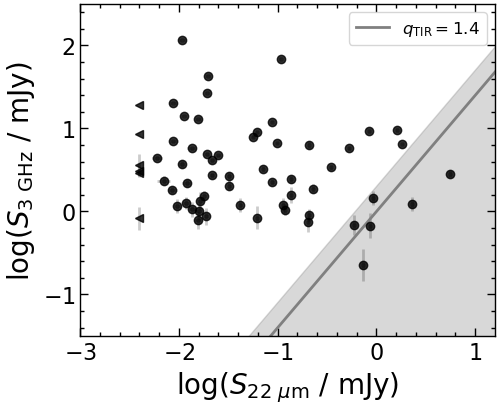

In [171]:
fig, ax = plt.subplots(1, 1, figsize=(5.2, 4.3))

F2L = 4*np.pi*(data_50Mpc['bestdist']*u.Mpc)**2
y = np.log10((data_50Mpc['Ftot']*u.mJy * F2L).to(u.erg/u.s, equivalencies=u.spectral_density(3*u.GHz)).value) # 15 % correction
yerr = 0.434 * np.log10((data_50Mpc['e_Ftot']*u.mJy * F2L).to(u.erg/u.s, equivalencies=u.spectral_density(3*u.GHz)).value) / y
yerr[~np.isfinite(yerr)] = -1

x = data_50Mpc['logmass']
xerr = np.sqrt((data_50Mpc['logmass_error'])**2 + 0.3**2)

# Exlude |b| < 30 deg
mask_b = np.abs(cat_50Mpc.transform_to('galactic').b) > 10*u.deg

# Exlude Virgo and Fornax
mask_virgo = cat_50Mpc.separation(SkyCoord.from_name('Virgo Cluster')) > 12*u.deg
mask_fornax = cat_50Mpc.separation(SkyCoord.from_name('Fornax Cluster')) > 1*u.deg

# Visibility
mask_vis = cat_50Mpc.dec > -40*u.deg

# Mask
mask_valid = mask_b & mask_virgo & mask_fornax & np.isfinite(x) & np.isfinite(y) & (data_50Mpc['z_gama'] < 0.012) & (data_50Mpc['z_dr16'] < 0.012) & mask_vis

data_50Mpc['_log_lr']  = y
data_50Mpc['_log_lr_err']  = yerr

data_50Mpc['logLIR']  = -1.0
data_50Mpc['logLIR_err']  = -1.0

dist = data_50Mpc['bestdist'].copy()
colortype = data_50Mpc['best_type'].copy()
d25 = data_50Mpc['d25'].copy()*60 # arcsec
mask_nod25 = ~np.isfinite(d25)
# 2 R50 = R100
# 2 R100 = d
# Start with size-mass relation
d25[mask_nod25 & (colortype=='early')] = 4 * 3.47*1e-5*(10**(x[mask_nod25 & (colortype=='early')]))**0.56 # 0.5 dex scatter
d25[mask_nod25 & (colortype=='late')] = 4 * 0.1*(10**(x[mask_nod25 & (colortype=='late')]))**0.14 * (1 + 10**(x[mask_nod25 & (colortype=='late')])/(3.98*1e10))**(0.39 - 0.14) # 0.5 dex scatter
d25[mask_nod25] = d25[mask_nod25] * cosmo.arcsec_per_kpc_proper(z_at_value(cosmo.comoving_distance, dist[mask_nod25]*u.Mpc)).value
# Start with average value for galaxies without best type
n = np.full(len(x), 2.5)
n[colortype=='early'] = 4.0
n[colortype=='late'] = 1.0

b = 2*n - 1/3
CI =  np.log10(gammainc(2*n, b*(1/(d25/2))**1/n)/gamma(2*n))

f_IR = 8.363 * 10**(-data_50Mpc['W4mag']/2.5)
ef_IR = np.log(10)/2.5 * data_50Mpc['e_W4mag'] * f_IR

mask_q = (ef_IR > 0) & (yerr > 0) & mask_valid

ax.errorbar(np.log10(f_IR[mask_q]) , np.log10(data_50Mpc['Ftot'][mask_q]),
            color='k', linestyle='none', marker='o', alpha=0.8);

ax.errorbar(np.log10(f_IR[mask_q]) , np.log10(data_50Mpc['Ftot'][mask_q]),
            xerr=np.abs(0.434 * ef_IR[mask_q] / f_IR[mask_q]),
            yerr=np.abs(0.434 * data_50Mpc['e_Ftot'][mask_q] / data_50Mpc['Ftot'][mask_q]),
            color='k', linestyle='none', marker='.', alpha=0.2);

# ESTIMATE FOR SFR-MS -LIR relation
# https://www.aanda.org/articles/aa/pdf/2017/06/aa29430-16.pdf
L_IR = 10**data_50Mpc['logSFR'] / (10**-4.75) * u.Lsun
f_IR[data_50Mpc['W4mag']<0] = (L_IR / F2L)[data_50Mpc['W4mag']<0].to(u.mJy, equivalencies=u.spectral_density(22*u.um)).value
# flag limit
f_IR[data_50Mpc['W4mag']<0] = 10**-2.4 # median
ef_IR[data_50Mpc['W4mag']<0] = 0.3

#b = 2*n - 1/3
#CI = np.log10(gammainc(2*n, b*(1/60)**1/n)/gamma(2*n))

data_50Mpc['logLIR'] = np.log10(L_IR.to(u.erg/u.s, equivalencies=u.spectral_density(22*u.um)).value)
data_50Mpc['logLIR_err'] = 0.434 * (ef_IR * F2L.value) / L_IR.value
data_50Mpc['logLIR_err'][data_50Mpc['W4mag']>0] = -1


mask_q = (ef_IR == 0.3) & (yerr > 0) & mask_valid

ax.errorbar(np.log10(f_IR[mask_q]) , np.log10(data_50Mpc['Ftot'][mask_q]),
            color='k', linestyle='none', marker='<', alpha=0.8);
ax.errorbar(np.log10(f_IR[mask_q]), np.log10(data_50Mpc['Ftot'][mask_q]),
            yerr=np.abs(0.434 * data_50Mpc['e_Ftot'][mask_q] / data_50Mpc['Ftot'][mask_q]),
            color='k', linestyle='none', marker='none', alpha=0.2);

x_eval = np.linspace(-2.5, 2)


# 0.84 = log10(SIR/S_R)

# S_R = (3/1.4)^alpha * S_R

# 0.84 = log10(SIR/ (3/1.4)^alpha * S_R)

# alpha = -0.7

# 1.4 = log10(SIR/SR)

# 1.4 = log10 SIR - log SR

# 1.4 + log SR = log10 SIR 


#ax.plot(x_eval, x_eval*0.84, color='k') # 0.3 dex

ax.plot(x_eval, x_eval*1.4, color='gray', label=r'$q_{\rm TIR} = 1.4$')
ax.fill_between(x_eval, x_eval*1.4 + 0.3, x_eval - 10, color='gray', alpha=0.3)

ax.set_xlabel(r'$\log( S_{22\ \mu {\rm m}}\ /$ mJy)', fontsize=20)
ax.set_ylabel(r'$\log( S_{3\ {\rm GHz}}\ /$ mJy)', fontsize=20)

ax.set_xlim(-3, 1.2)
ax.set_ylim(-1.5, 2.5)

ax.legend(fontsize=12, frameon=True)
fig.tight_layout()
fig.savefig('q.pdf', dpi=300)

# https://www.aanda.org/articles/aa/pdf/2017/06/aa29430-16.pdf

(0.0, 3600.0)

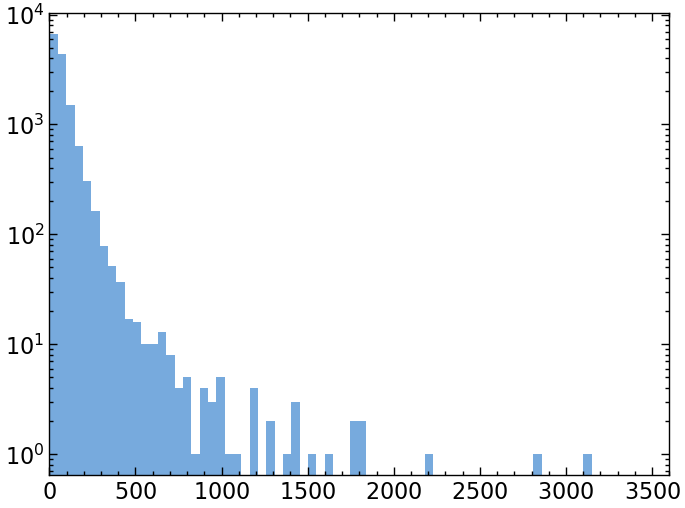

In [172]:
#plt.hist(d25[mask_nod25], log=True, bins=100)
plt.hist(data_50Mpc['d25']*60, log=True, bins=800, zorder=-1);
plt.xlim(0, 60*60)

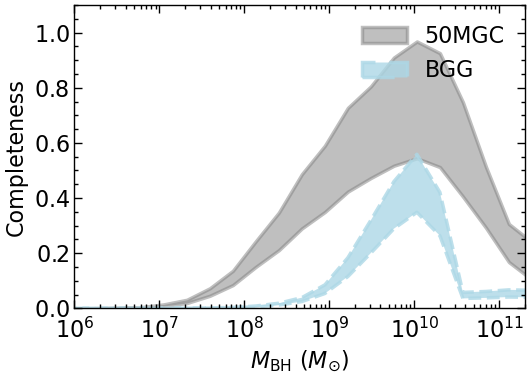

In [173]:
Ms = 10**10.745
phi1 = 10**-2.437
phi2 = 10**-3.201
alpha1 = -0.466
alpha2 = -1.530

_M = np.logspace(5, 11.5, 25)
dM = np.diff(_M)
M = _M[:-1] + dM/2
phidM = np.exp(-M/Ms)*(phi1*(M/Ms)**alpha1 + phi2*(M/Ms)**alpha2) * dM/Ms
#plt.loglog(M, phidM/np.diff(np.log10(_M)))
#plt.ylim(1e-5, 1e0)

# Draw from the GSMF
def inv_transform_sampling(y, x, n_samples=1000):
    """
    Perform inverse transform sampling on curve y(x)
    https://tmramalho.github.io/blog/2013/12/16/how-to-do-inverse-transformation-sampling-in-scipy-and-numpy/
    https://en.wikipedia.org/wiki/Inverse_transform_sampling
    """
    dx = np.diff(x)
    cum_values = np.zeros(x.shape)
    cum_values[1:] = np.cumsum(y*dx)/np.sum(y*dx)
    r = np.random.rand(int(n_samples))
    return np.interp(r, cum_values, x)

# Plot

#fig, ax0 = plt.subplots(1, 1, figsize=(6, 4.5))
fig, ax1 = plt.subplots(1, 1, figsize=(5.5, 4.0))


# X-ray
V = 4/3*np.pi*(50)**3
N_draw = int(V*np.trapz(phidM))
completeness_50MGC = np.zeros([len(_M)-1, 30])
for i in range(25):
    M_star = inv_transform_sampling(phidM/dM, _M, N_draw)

    h, bin_edges = np.histogram(M_star, bins=_M)
    #ax0.loglog(M, h, color='r', lw=2.5, label='model GSMF')

    # Exlude |b| < 30 deg
    mask_b = np.abs(cat_50Mpc.transform_to('galactic').b) > 10*u.deg

    # Exlude Virgo and Fornax
    mask_virgo = cat_50Mpc.separation(SkyCoord.from_name('Virgo Cluster')) > 12*u.deg
    mask_fornax = cat_50Mpc.separation(SkyCoord.from_name('Fornax Cluster')) > 1*u.deg

    mask = mask_b & mask_virgo & mask_fornax & (data_50Mpc['z_dr16'] < 0.12) & (data_50Mpc['z_gama'] < 0.12) #& (data_50Mpc['_log_lx'] > 0)
    h, bin_edges = np.histogram(10**data_50Mpc['logmass'][mask], bins=_M)
    #ax0.loglog(M, h, color='r', linestyle='dashed', lw=2.5, label='50MGC')

    # Completeness
    hist_model, bin_edges = np.histogram(M_star, bins=_M)
    hist, bin_edges = np.histogram(10**data_50Mpc['logmass'][mask], bins=_M)
    completeness_50MGC[:,i] = hist/hist_model
    completeness_50MGC[~np.isfinite(hist/hist_model),i] = 10
    #ax1.semilogx(M, completeness_50MGC, color='r', label='50MGC', linestyle='dashed', lw=2.5)

ax1.fill_between(M, np.percentile(completeness_50MGC, 16, axis=1), np.percentile(completeness_50MGC, 84, axis=1),
                color='gray', label='50MGC', linestyle='solid', lw=2.5, alpha=0.5)


import pandas as pd
data_bgg = pd.read_excel('NSAVariability_wmasses_101319.xlsx')
data_bgg = Table.from_pandas(data_bgg)
data_bgg['nsaid'] = np.array([s[3:] for s in data_bgg['ObjID']], dtype=int)
cat_bgg = SkyCoord(data_bgg['RA'], data_bgg['Dec'], unit=u.deg)

# Variability
omega = (9380*u.deg**2).to(u.sr)
V = (cosmo.comoving_volume(0.055)*omega/(4*np.pi)).value
N_draw = int(V*np.trapz(phidM))
completeness_BGG = np.zeros([len(_M)-1, 30])
for i in range(25):
    M_star = inv_transform_sampling(phidM/dM, _M, N_draw)
    # Add some scatter
    M_star = 10**(np.log10(M_star) + np.random.normal(0, 0.3, len(M_star)))

    hist_model, bin_edges = np.histogram(M_star, bins=_M)
    #ax0.loglog(M, hist_model, color='b', lw=2.5, label='model GSMF')

    stellar_mass = data_bgg['Mstar']
    hist, bin_edges = np.histogram(stellar_mass, bins=_M)

    #ax0.loglog(M, hist, color='b', linestyle='dotted', lw=2.5, label='BGG')

    hist_model, bin_edges = np.histogram(M_star, bins=_M)
    completeness_BGG[:,i] = hist/hist_model
    completeness_BGG[~np.isfinite(hist/hist_model),i] = 10
    #ax1.semilogx(M, completeness_BGG, color='b', label='BGG', linestyle='dashed', lw=2.5)

ax1.fill_between(M, np.percentile(completeness_BGG, 16, axis=1), np.percentile(completeness_BGG, 84, axis=1),
                color='lightblue', label='BGG', linestyle='dashed', lw=2.5, alpha=0.8)

#####


ax1.set_xlim(1e6, 2e11)
ax1.set_ylim(0, 1.1)

ax1.set_xscale('log')


ax1.set_xlabel(r'$M_{\rm{BH}}$ ($M_{\odot}$)')
ax1.set_ylabel(r'Completeness')
ax1.legend(fontsize=16)

# Axis
locmaj = matplotlib.ticker.LogLocator(base=10,numticks=14) 
ax1.xaxis.set_major_locator(locmaj)
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9),numticks=14)
ax1.xaxis.set_minor_locator(locmin)
ax1.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

ax1.tick_params(axis='x', which='major', pad=7)


fig.tight_layout()
fig.savefig('completeness.pdf', dpi=300)

In [174]:
os.environ["OMP_NUM_THREADS"] = "1"

#from multiprocessing import Pool
from multiprocess import Pool

from multiprocessing import cpu_count
ncpu = cpu_count() - 1
print("{0} CPUs".format(ncpu))

7 CPUs


/var/folders/kx/qz91z8390zqfjrd9v6mt61w00000gn/T/ipykernel_62538/1987102197.py:2: RuntimeWarning: divide by zero encountered in log10
  _y = np.log10((data_50Mpc['Ftot']*u.mJy * F2L).to(u.erg/u.s, equivalencies=u.spectral_density(3*u.GHz)).value) # 15 % correction
/var/folders/kx/qz91z8390zqfjrd9v6mt61w00000gn/T/ipykernel_62538/1987102197.py:3: RuntimeWarning: divide by zero encountered in log10
  _yerr = 0.434 * np.log10((data_50Mpc['e_Ftot']*u.mJy * F2L).to(u.erg/u.s, equivalencies=u.spectral_density(3*u.GHz)).value) / _y
/var/folders/kx/qz91z8390zqfjrd9v6mt61w00000gn/T/ipykernel_62538/1987102197.py:3: RuntimeWarning: invalid value encountered in log10
  _yerr = 0.434 * np.log10((data_50Mpc['e_Ftot']*u.mJy * F2L).to(u.erg/u.s, equivalencies=u.spectral_density(3*u.GHz)).value) / _y
/var/folders/kx/qz91z8390zqfjrd9v6mt61w00000gn/T/ipykernel_62538/1987102197.py:3: RuntimeWarning: invalid value encountered in divide
  _yerr = 0.434 * np.log10((data_50Mpc['e_Ftot']*u.mJy * F2L).to(u.erg/u

[1. 1. 1. ... 1. 1. 1.]


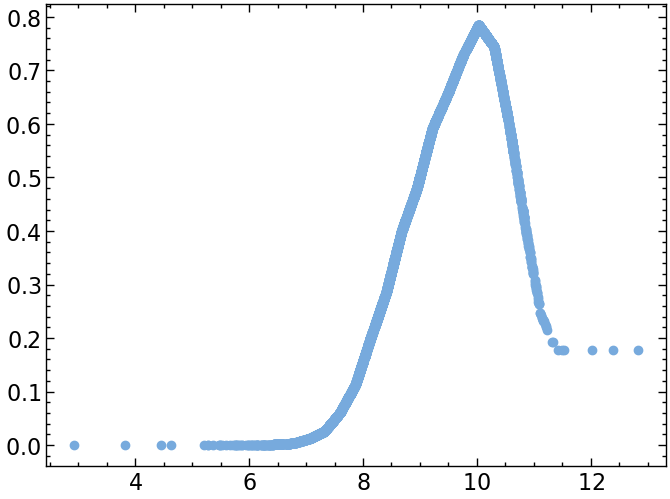

In [175]:
F2L = 4*np.pi*(data_50Mpc['bestdist']*u.Mpc)**2
_y = np.log10((data_50Mpc['Ftot']*u.mJy * F2L).to(u.erg/u.s, equivalencies=u.spectral_density(3*u.GHz)).value) # 15 % correction
_yerr = 0.434 * np.log10((data_50Mpc['e_Ftot']*u.mJy * F2L).to(u.erg/u.s, equivalencies=u.spectral_density(3*u.GHz)).value) / _y
_yerr[~np.isfinite(_yerr)] = -1

#y[~np.isfinite(yerr)] *= 500

_x = data_50Mpc['logmass']
_xerr = np.sqrt((data_50Mpc['logmass_error'])**2 + 0.3**2)

# Exlude |b| < 30 deg
mask_b = np.abs(cat_50Mpc.transform_to('galactic').b) > 10*u.deg

# Exlude Virgo and Fornax
mask_virgo = cat_50Mpc.separation(SkyCoord.from_name('Virgo Cluster')) > 12*u.deg
mask_fornax = cat_50Mpc.separation(SkyCoord.from_name('Fornax Cluster')) > 1*u.deg

# Visibility
mask_vis = cat_50Mpc.dec > -40*u.deg

# Mask
mask_valid = mask_b & mask_virgo & mask_fornax & np.isfinite(_x) & np.isfinite(_y) & (data_50Mpc['z_gama'] < 0.012) & (data_50Mpc['z_dr16'] < 0.012) & mask_vis
x = _x[mask_valid]
xerr = _xerr[mask_valid]
y = _y[mask_valid]
yerr = _yerr[mask_valid]
dist = data_50Mpc['bestdist'].copy()[mask_valid]
colortype = data_50Mpc['best_type'].copy()[mask_valid]
d25 = data_50Mpc['d25'].copy()[mask_valid]*60 # arcsec
mask_nod25 = ~np.isfinite(d25)
# 2 R50 = R100
# 2 R100 = d
# Start with size-mass relation
d25[mask_nod25 & (colortype=='early')] = 4 * 3.47*1e-5*(10**(x[mask_nod25 & (colortype=='early')]))**0.56 # 0.5 dex scatter
d25[mask_nod25 & (colortype=='late')] = 4 * 0.1*(10**(x[mask_nod25 & (colortype=='late')]))**0.14 * (1 + 10**(x[mask_nod25 & (colortype=='late')])/(3.98*1e10))**(0.39 - 0.14) # 0.5 dex scatter
d25[mask_nod25] = d25[mask_nod25] * cosmo.arcsec_per_kpc_proper(z_at_value(cosmo.comoving_distance, dist[mask_nod25]*u.Mpc)).value
# Start with average value for galaxies without best type
n = np.full(len(x), 2.5)
n[colortype=='early'] = 4.0
n[colortype=='late'] = 1.0
print(n)

logLIR = data_50Mpc['logLIR'][mask_valid]
logLIRerr = data_50Mpc['logLIR_err'][mask_valid]


p_obs = np.clip(np.interp(x, np.log10(M), np.mean(completeness_50MGC, axis=1)), 1e-6, 1)
#p_obs = np.ones_like(x)
plt.scatter(x, p_obs)

# Save the input for multiwavelength analysis!
tvar = Table([x, y, xerr, yerr, logLIR, logLIRerr, d25, n, p_obs], names=['x', 'y', 'xerr', 'yerr', 'loglir', 'loglirerr', 'd25', 'n', 'pobs'])
tvar.write('tvla.txt', overwrite=True, format='ascii')

## INFERENCE

nsamp=500
nburn=200
scale_hist=1
color='C2'
ylims=[None, None]


In [ ]:

#np.random.seed(424)
nll = lambda *args: -log_likelihood_init(*args)

# log probability global
args_global = (x, y, xerr, yerr, logLIR, logLIRerr, d25, n, p_obs)
def log_probability(theta):
    x, y, xerr, yerr, logLIR, logLIRerr, d25, n, p_obs = args_global
    lp = log_prior(theta)
    ll = log_likelihood(theta, x, y, xerr, yerr, logLIR, logLIRerr, d25, n, p_obs)
    if not np.isfinite(lp) or not np.isfinite(ll):
        return -np.inf
    return lp + ll

#      logms0, alpha, beta,    log_f,  f_a, delta, theta
pos = [10, -9, 0.2, -0.8, 0.2, 1, 1]
pos = np.array(pos) + 1e-4 * np.random.randn(32, len(pos))
nwalkers, ndim = pos.shape

ncpu = 1

# Sampler
if ncpu > 1:
    with Pool() as pool:
        sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, pool=pool)
        sampler.run_mcmc(pos, nsamp, progress=True);
else:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability)
    sampler.run_mcmc(pos, nsamp, progress=True);



(1920, 7)
[1880 3806 4914 3652  435 6000  521 3681  988 3891 4734 7737 8019 8734
 1391 1567 8196 4743 4753 8029 4479 8292 1117 7790 5950 4078 2986  432
 5200  781 4727 4321 1802 2661 1583 5976 2914 4873 2567 1268 6578  957
 8138 1610 3050 7033 5009  791 6626 6875]


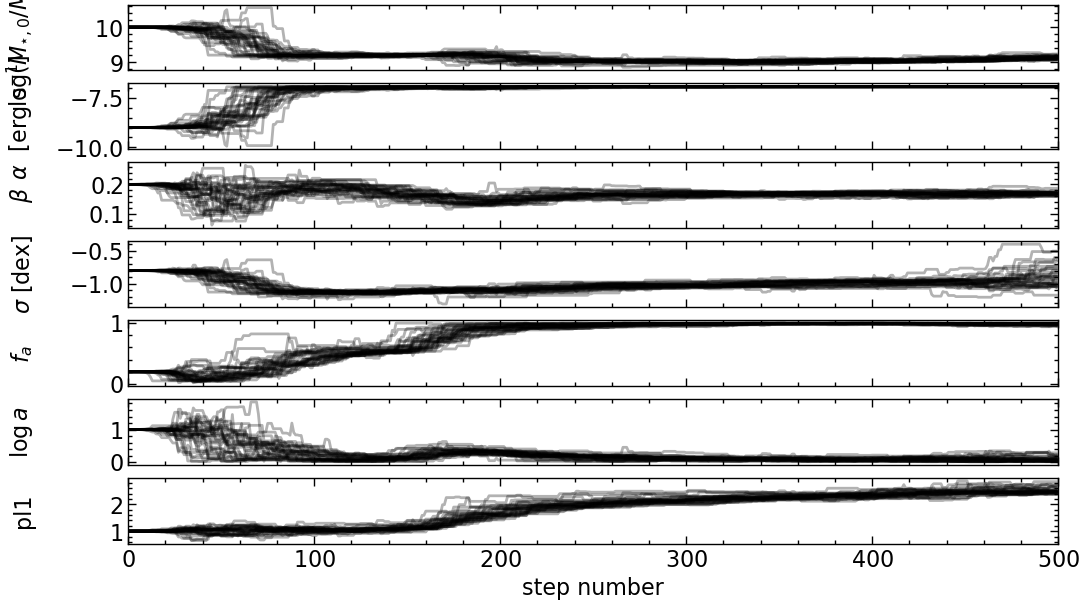

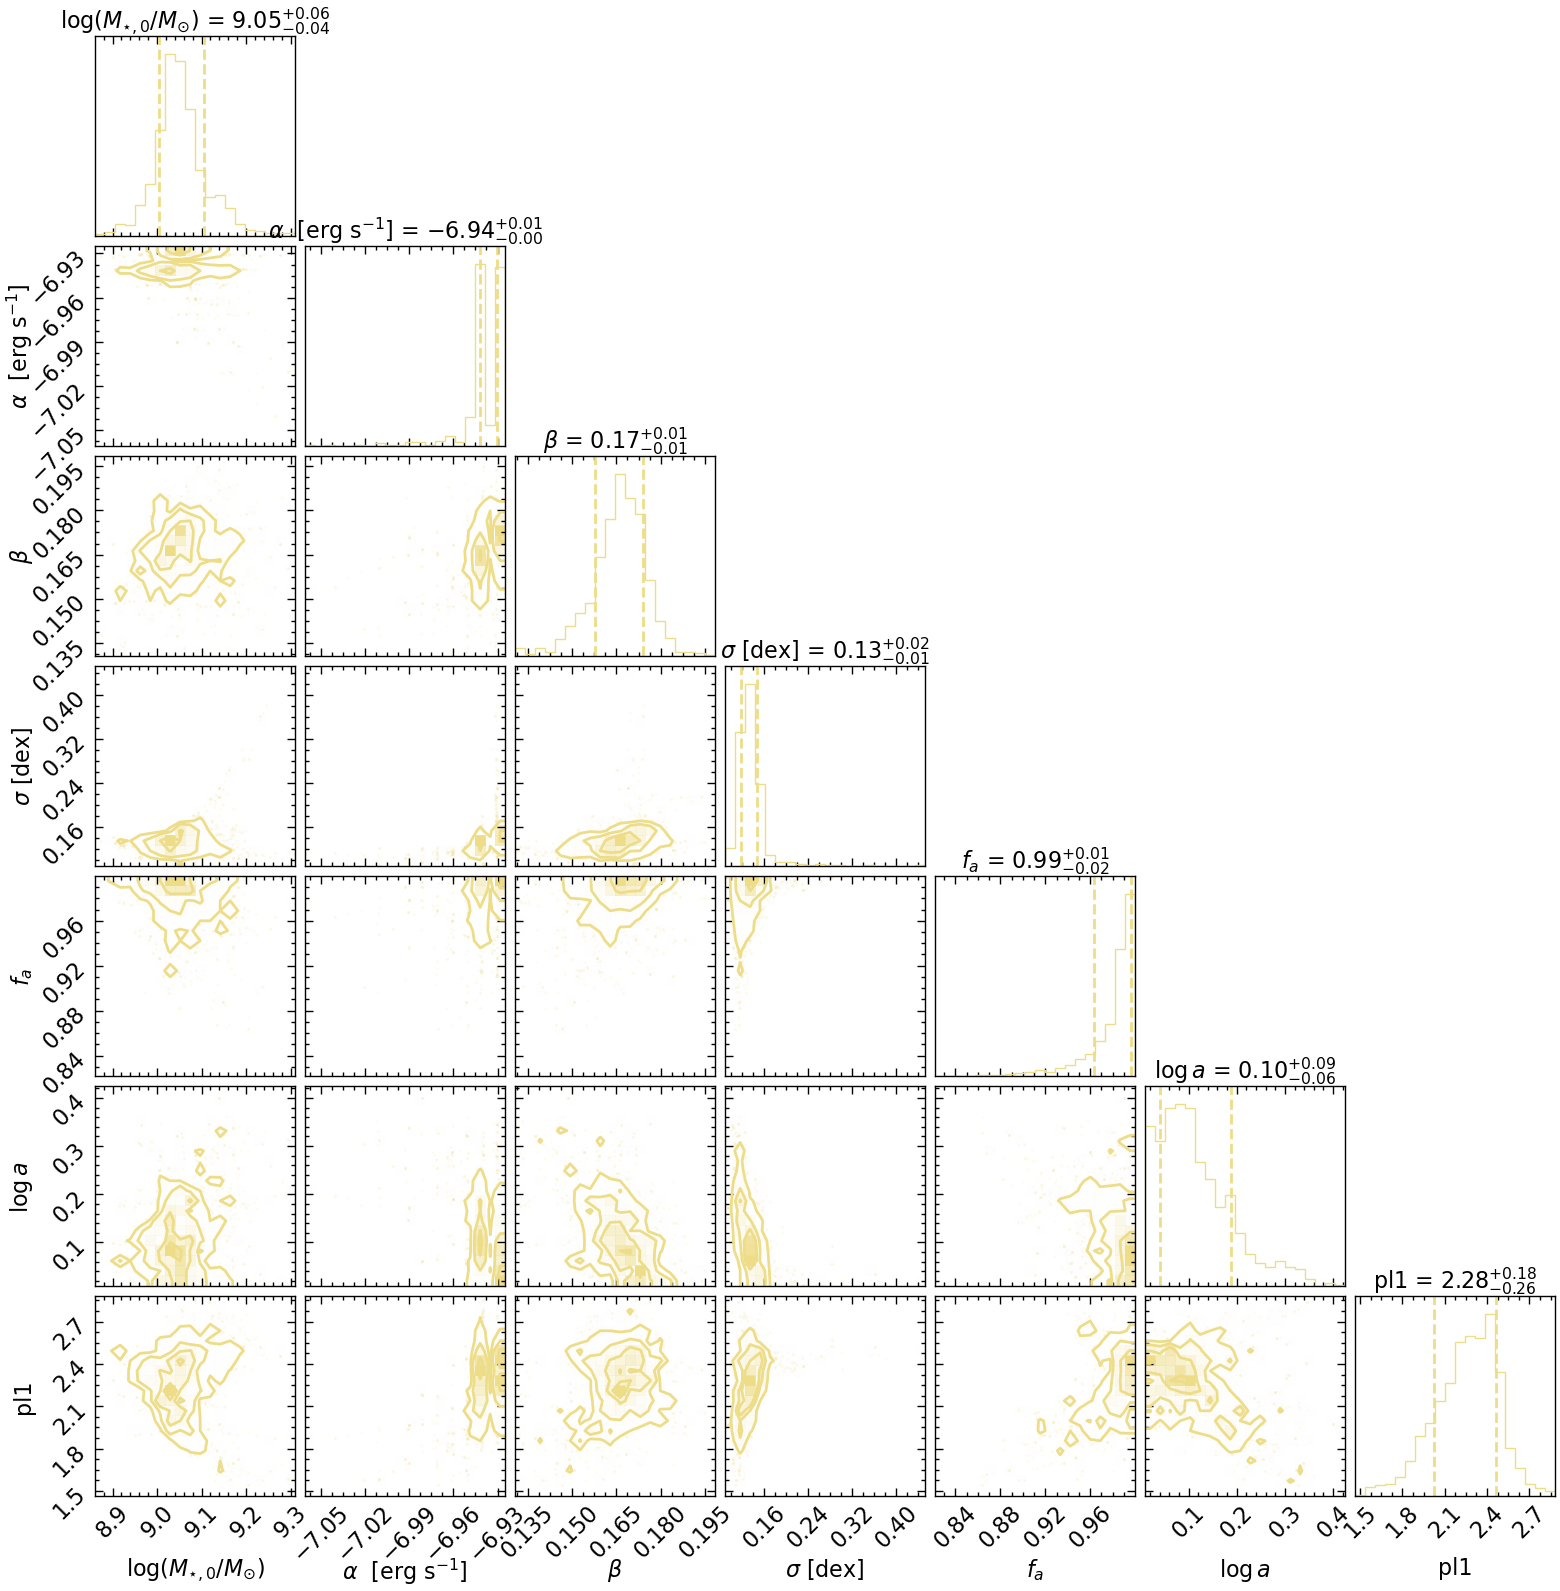

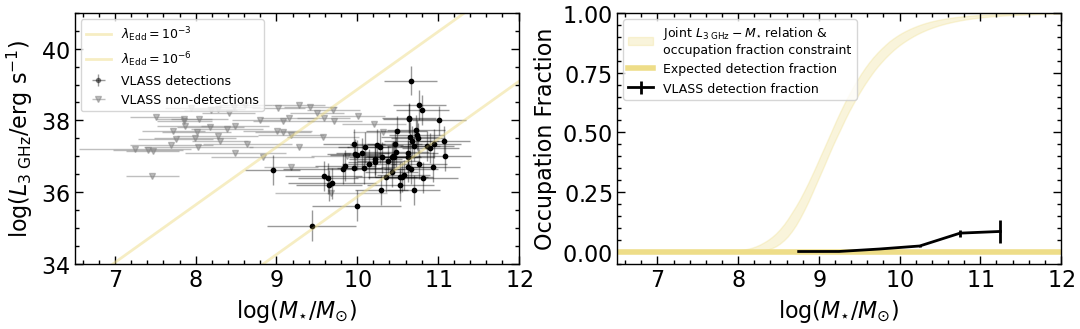

In [183]:
# Plot
fig, axes = plt.subplots(ndim, figsize=(12, 7), sharex=True)
samples = sampler.get_chain()

labels = [r"$\log(M_{\star,0}/M_{\odot})$", r"$\alpha$  [erg s$^{-1}$]", r"$\beta$", r"$\sigma$ [dex]", r"$f_a$", r"$\log a$", 'pl1']

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

#tau = sampler.get_autocorr_time()
#print(tau)

flat_samples = sampler.get_chain(discard=nburn, thin=5, flat=True)
print(flat_samples.shape)

# Corner
flat_samples[:,3] = np.exp(2*flat_samples[:,3]) # sigma
fig_corner = corner.corner(flat_samples, labels=labels, quantiles=[0.16, 0.84], color=color, show_titles=True)

# TODO::::: Increase the 1st column limit + 1 and use 95th percentile

fig, axes = plt.subplots(1, 2, figsize=(11, 3.5))
#inds = np.random.randint(len(flat_samples), size=100)

# Plot data
x_eval = np.linspace(5, 15, 200)
axes[0].scatter(x[yerr > 0], y[yerr > 0], marker='.', color='k')
axes[0].errorbar(x[yerr > 0], y[yerr > 0], elinewidth=1,
                    xerr=xerr[yerr > 0], yerr=yerr[yerr > 0],
                    fmt=".k", capsize=0, alpha=0.4, label='VLASS detections')
# Pick random
if len(x[yerr < 0]) > 50:
    ind_rand = np.random.choice(len(x[yerr < 0]), 50, replace=False)
else:
    ind_rand = np.arange(len(x[yerr < 0]))
print(ind_rand)
axes[0].errorbar(x[yerr < 0][ind_rand], y[yerr < 0][ind_rand],
                    xerr=xerr[yerr < 0][ind_rand], elinewidth=1, markersize=5,
                    marker="v", linestyle="none", color="gray", alpha=0.5, capsize=0, zorder=-1, label='VLASS non-detections')
#axes[0].errorbar(x[(yerr < 0) & (y<40)] + xp, y[(yerr < 0) & (y<40)] + yp,
#                    xerr=xerr[(yerr < 0) & (y<40)], elinewidth=1,
#                    marker="v", linestyle="none", color="gray", alpha=0.5, capsize=0, zorder=-1)
#axes[0].legend(fontsize=14)
axes[0].set_xlim([6.5, 12])
axes[0].set_ylim([34, 41])
axes[0].set_xlabel(r'$\log(M_{\star} / M_{\odot})$')
axes[0].set_ylabel(r'$\log(L_{3\ {\rm{GHz}}} / {\rm{erg}}\ {\rm{s}}^{-1})$')

# Accretion rates
x_bh_eval = 7.43 + 1.61*(x_eval - np.log10(3e10)) # 0.81
BC = 3 # Bolometric correction
y_eval = -BC + 38.2 + x_bh_eval
axes[0].plot(x_eval, y_eval-3, color=color, alpha=0.5, zorder=2, label=r'$\lambda_{\rm{Edd}} = 10^{-3}$')

axes[0].plot(x_eval, y_eval-6, color=color, alpha=0.5, zorder=2, label=r'$\lambda_{\rm{Edd}} = 10^{-6}$')


# Occupation fraction
foccs = np.zeros([len(flat_samples), len(x_eval)])
for i, s in enumerate(flat_samples):
    #foccs[i,:] = 1/(1 + np.exp(s[5]) * np.exp(-s[6]*(x_eval - s[0])))**(1/np.exp(s[5]))
    foccs[i,:] = 1/(1 + s[5] * np.exp(-s[6]*(x_eval - s[0])))**(1/s[5])

#axes[1].plot(x_eval + xp, f_occ_low, color, alpha=0.1)
axes[1].fill_between(x_eval, np.percentile(foccs, 16, axis=0),  np.percentile(foccs, 84, axis=0), color=color, alpha=0.3,
                        label=r'Joint $L_{3\ {\rm{GHz}}} - M_{\star}$ relation &'+'\n'+'occupation fraction constraint')

# Histogram
hist_det, bin_edges = np.histogram(x[yerr>0], bins=np.arange(5, 13, 0.5))
hist_all, bin_edges = np.histogram(x,  bins=np.arange(5, 13, 0.5))
frac_det = hist_det/hist_all

bincenter = (bin_edges[:-1] + bin_edges[1:]) / 2

fa50 = np.median(flat_samples[:,4])
axes[1].errorbar(bincenter[hist_det>0], scale_hist * fa50 * frac_det[hist_det>0],
                    yerr=scale_hist*st.binom.std(hist_all[hist_det>0], frac_det[hist_det>0])/hist_all[hist_det>0],
                    color="k", capsize=0, label='VLASS detection fraction')


# Expectation fraction
fexp = np.zeros([len(flat_samples), len(x_eval)])
for i, s in enumerate(flat_samples):
    alphai = flat_samples[i,1]
    betai = flat_samples[i,2]
    si = flat_samples[i,3]
    fa50 = flat_samples[i,4]
    y_lim = np.median(y[(yerr<0) & (x>10)])
    fexp[i,:] = fa50 * foccs[i,:] * st.norm.sf(y_lim, alphai + betai*(x_eval), si)

axes[1].plot(x_eval, np.percentile(fexp, 95, axis=0), color=color, lw=4, label=r'Expected detection fraction')

#y_lim = np.median(y[(yerr<0) & (x+xp>9.0)])+yp
#axes[1].plot(x_eval+xp, np.percentile(foccs, 50, axis=0) * st.norm.sf(y_lim, yp + alpha_x50 + beta_x50*(x_eval), sigma50),
#             color=color, lw=4, label=r'Expected detection fraction')

axes[1].set_xlim([6.5, 12])
axes[1].set_ylim([None, 1])
axes[1].set_xlabel(r"$\log(M_{\star} / M_{\odot})$")
axes[1].set_ylabel(r"Occupation Fraction")

axes[0].legend(fontsize=9, frameon=True, loc='upper left')
axes[1].legend(fontsize=9, frameon=True, loc='upper left')

## IF you see nothing it means init is outside of prior bounds 
# or you have inf/nans in the data

fig.tight_layout()
fig_corner.savefig('corner_vlass.pdf', dpi=300)
fig.savefig('bhofradio.pdf', dpi=300)

In [177]:
np.save('focc_vlass', foccs)
np.save('flat_samples_radio', flat_samples)

In [178]:
flat_samples = np.load('flat_samples_radio.npy')

In [179]:
mask = mask_b & mask_virgo & mask_fornax & np.isfinite(_x) & np.isfinite(_y) & np.isfinite(_xerr) & np.isfinite(_yerr) & \
    (data_50Mpc['z_dr16'] < 0.012) & (data_50Mpc['z_gama'] < 0.012) & (_y > 0) & mask_vis

# Only include detections 

cols = ['objname', 'ra', 'dec', 'bestdist', 'bestdist_error', 'logmass', 'logmass_error', '_log_lr', '_log_lr_err', 'logLIR', 'logLIR_err', 'best_type']
# Write to latex
#data_50Mpc[mask][(y>0) & (yerr>0) & (x<8)]
data_50Mpc_out = data_50Mpc[mask][(y>0) & (yerr>0)]
data_50Mpc_out['_log_lr'] = np.round(data_50Mpc_out['_log_lr'], 2)
data_50Mpc_out['_log_lr_err'] = np.round(data_50Mpc_out['_log_lr_err'], 2)
data_50Mpc_out['logLIR'] = np.round(data_50Mpc_out['logLIR'], 2)
data_50Mpc_out['logLIR_err'] = np.round(data_50Mpc_out['logLIR_err'], 2)
data_50Mpc_out.write('radiotable.mrt', format='mrt', overwrite=True, include_names=cols)  
data_50Mpc_out['ra'] = np.round(data_50Mpc_out['ra'], 4)
data_50Mpc_out['dec'] = np.round(data_50Mpc_out['dec'], 4)
data_50Mpc_out.write('radiotable.tab', format='latex', overwrite=True, include_names=cols)  

# Write to mrt

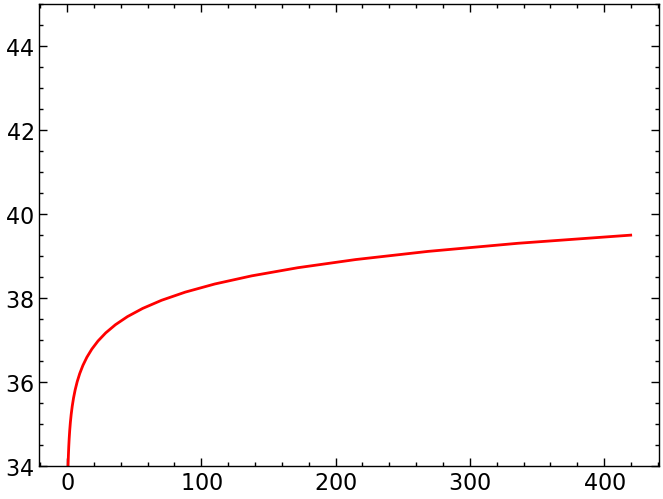

In [180]:
plt.scatter(dist, y+yp)
plt.scatter(dist[yerr>0], y[yerr>0]+yp)

sens_lim = 5*(1*u.mJy).to(u.erg/u.s/u.cm**2, equivalencies=u.spectral_density(3*u.GHz)).value

log_l_eval = np.linspace(30, 39.5)
l_eval = 10**log_l_eval

d = np.sqrt(l_eval / (sens_lim * 4*np.pi))
d = (d*u.cm).to(u.Mpc).value
Vmax = 4/3*np.pi*d**3 * 13/180 # area
#log_l_med = np.log10(sens_med*4*np.pi*d**2)
plt.plot(d, log_l_eval, color='r')
plt.ylim(34, 45)

def invVmax_l(logl):
    return np.interp(logl, log_l_eval, 1/Vmax)

In [181]:
logms_eval = np.linspace(4, 11)
 
# LX - Ms relation

logl = yp + alpha_x50 + beta_x50*(logms_eval - xp) 
l = 10**logl

d = np.sqrt(l / (sens_lim * 4*np.pi))
d = (d*u.cm).to(u.Mpc).value
Vmax = 4/3*np.pi*d**3 * 130/180
#log_l_med = np.log10(sens_med*4*np.pi*d**2)
plt.plot(d, logms_eval, color='r')

plt.scatter(dist, x+xp)
plt.scatter(dist[yerr>0], x[yerr>0]+xp)

def invVmax_m(log_mstar):
    return np.interp(log_mstar, logms_eval, 1/Vmax)

NameError: name 'xp' is not defined

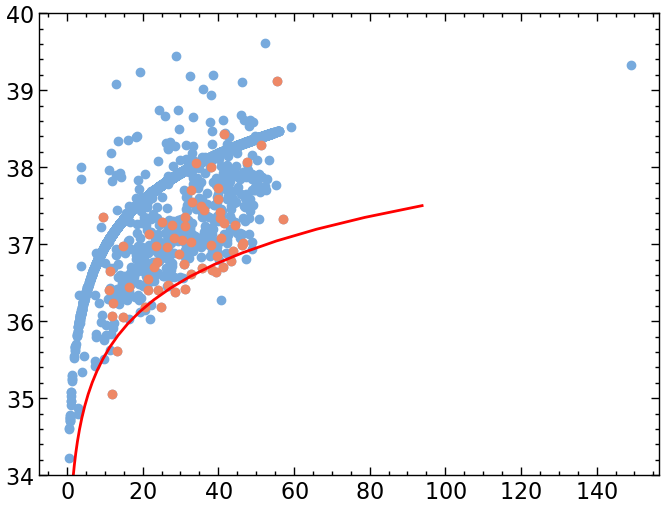

In [ ]:
plt.scatter(dist, y+yp)
plt.scatter(dist[yerr>0], y[yerr>0]+yp)

log_l_eval = np.linspace(30, 37.5)
l_eval = 10**log_l_eval

d = np.sqrt(l_eval / (sens_lim * 4*np.pi))
d = (d*u.cm).to(u.Mpc).value
Vmax = 4/3*np.pi*d**3* 130/180
#log_l_med = np.log10(sens_med*4*np.pi*d**2)
plt.plot(d, log_l_eval, color='r')
plt.ylim(34, 40)

def invVmax_l(logl):
    return np.interp(logl, log_l_eval, 1/Vmax)

In [ ]:
def logGSMF(M_star, size=1):
    """
    Galaxy stellar mass function of the z ~ 0 blue+green galaxy population (single Schechter function)
    https://ui.adsabs.harvard.edu/abs/2012MNRAS.421..621B/abstract
    """
    logM_br = 10.78
    dlogM_br = 0.01
    
    phi1 = 2.96*1e-3
    dphi1 = 0.40*1e-3
    
    phi2 = 0.63*1e-3
    dphi2 = 0.10*1e-3
    
    alpha1 = -0.62
    dalpha1 = 0.03
    
    alpha2 = -1.50
    dalpha2 = 0.01
    
    M_br = 10**np.random.normal(loc=logM_br, scale=dlogM_br, size=size)*u.Msun
    phi1 = np.random.normal(loc=phi1, scale=dphi1, size=size)*u.Mpc**-3
    
    phi2 = np.random.normal(loc=phi2, scale=dphi2, size=size)*u.Mpc**-3
    
    alpha1 = np.random.normal(loc=alpha1, scale=dalpha1, size=size)
    alpha2 = np.random.normal(loc=alpha2, scale=dalpha2, size=size)

    # dN/dlogM
    phi = np.log(10) * np.exp(-M_star/M_br) * (phi1*(M_star/M_br)**(alpha1+1) + phi2*(M_star/M_br)**(alpha2+1))
    
    return phi

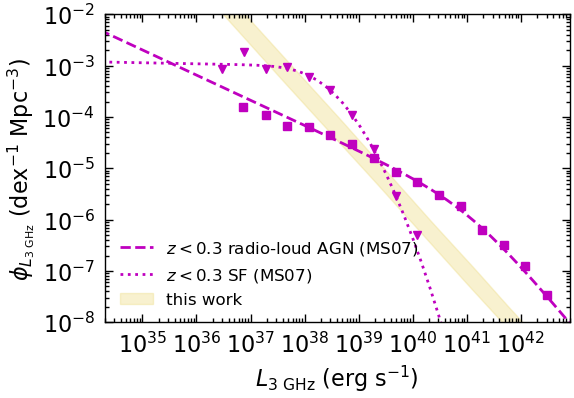

In [ ]:
fig3, ax3 = plt.subplots(1, 1, figsize=(6, 4.0))
ax3.set_xscale('log')
ax3.set_yscale('log')

#TODO: Check bin center

# grid
dlogm = 0.1
logms = np.arange(2.0, 20.5, dlogm)
ms = 10**logms
dms = np.diff(ms)

dloglam = 0.1
loglam_eval = np.arange(-15, 4, dloglam)
lam_eval = 10**loglam_eval
dlam_eval = np.diff(lam_eval)

Nsamp = 200 
#Nsamp = len(flat_samples)

gsmf = np.zeros([len(logms), Nsamp])
bhmf1 = np.zeros([len(logms), Nsamp])
bhmf = np.zeros([len(logms), Nsamp])
bhmf_agn = np.zeros([len(logms), Nsamp])
bhlf = np.zeros([len(logms), Nsamp])

foccs = np.zeros([len(logms), Nsamp])


for i in range(Nsamp):

    # total BH mass function is dominated by inactive population
    # GSH20, All, limits
    alpha_m = np.random.normal(7.43, 0.09, size=1)
    beta_m = np.random.normal(1.61, 0.12, size=1)
    sigma_m = np.random.normal(0.81, 0.06, size=1)
    logms0_m = np.log10(3*1e10)

    # grid
    logmb = alpha_m + beta_m*(logms - logms0_m)
    mb = 10**logmb
    dmb = np.diff(mb)

    # LX - Ms relation
    x_bh_eval = 7.43 + 1.61*(logms - np.log10(3e10)) # 0.81
    logl = -1 + 38.2 + x_bh_eval
    l = 10**logl
    dl = np.diff(l)
    dlogl = np.diff(logl)[0]

    gsmf[:,i] = logGSMF(ms*u.Msun, size=1).value

    # Convolve
    xii = np.exp(flat_samples[i,5])
    theta2i = flat_samples[i,6]
    x50i = flat_samples[i,0]
    foccs[:,i] = 1/(1 + xii * np.exp(-theta2i*(logms - x50i)))**(1/xii)

    alpha = 1 + flat_samples[i,2]
    lam_min = 10**flat_samples[i,1]

    pdf_pl = (alpha-1) * lam_min**(alpha-1) * lam_eval**-alpha # This is the INTRINSIC ERDF

    xi_star = 10**-9.64

    bhmfi = np.array([np.trapz(foccs[:,i] * gsmf[:,i] * st.norm.pdf(logmbi-logms, loc=logmb-logms, scale=sigma_m)*dlogm) for logmbi in logmb])

    # Convolve
    # fa
    #bhlf[:,i] = np.array([np.trapz(fa * foccs[:,i] * gsmf[:,i] * st.norm.pdf(logli-logms, loc=logl-logms, scale=sigma_l)*dlogm) for logli in logl])
    bhlf[:,i] = np.array([np.trapz(np.interp(logli - loglam_eval, logmb + 38.2, bhmfi) * pdf_pl * xi_star * dloglam) for logli in logl])


###
C = 10**-5.50
Ps = 10**24.59
alpha = -1.27
beta = -0.49
P = (l*u.erg/u.s).to(u.W/u.Hz, equivalencies=u.spectral_density(3*u.GHz)).value
ax3.plot(l, C/( (Ps/P)**alpha + (Ps/P)**beta ) * (3/1.4)**-0.5, color='m', linestyle='dashed', label='$z<0.3$ radio-loud AGN (MS07)')

C = 10**-2.83
Ps = 10**21.18
alpha = 1.02
s = 0.60
ax3.plot(l, C * (P/Ps)**(1-alpha) * np.exp( -0.5*(np.log10(1+P/Ps)/s)**2) * (3/1.4)**-0.5, color='m', linestyle='dotted', label='$z<0.3$ SF (MS07)')


# Save the result (and read in in the X-ray)
np.save('focc_vlass', foccs)

dat = ascii.read('mauch_agn.dat')
ax3.errorbar((10**dat['col1']*u.W/u.Hz).to(u.erg/u.s, equivalencies=u.spectral_density(3*u.GHz)),
             10**dat['col2'] * (3/1.4)**-0.5, linestyle='none', marker='s', color='m')
dat = ascii.read('mauch_sf.dat')
ax3.errorbar((10**dat['col1']*u.W/u.Hz).to(u.erg/u.s, equivalencies=u.spectral_density(3*u.GHz)),
             10**dat['col2'] * (3/1.4)**-0.5, linestyle='none', marker='v', color='m')

#dat = ascii.read('lts.txt')
#ax3.errorbar((10**dat['col1']*u.W/u.Hz).to(u.erg/u.s, equivalencies=u.spectral_density(3*u.GHz)),
#             10**dat['col2'], linestyle='none', marker='s', color='m')

##### 1/Vmax #####
bins = np.linspace(36, 39, 5)
n, bins = np.histogram((y+yp)[(yerr > 0)], weights=5*(invVmax_l(y+yp))[(yerr > 0)]/p_obs[(yerr > 0)], bins=bins)
err, bins = np.histogram((y+yp)[(yerr > 0)], weights=((invVmax_l(y+yp))[(yerr > 0)]/p_obs[(yerr > 0)])**2, bins=bins)
bin_centers = (bins[:-1] + bins[1:]) / 2
ax3.errorbar(10**bin_centers, n, yerr=np.sqrt(err), linestyle='none', marker='o', color=color)

########
ax3.fill_between(l, np.percentile(bhlf, 16, axis=1), np.percentile(bhlf, 84, axis=1), color=color, alpha=0.4, label='this work')
#ax3.set_xlim(1e37, 1e48)
ax3.set_xlim(2e34, 8e42)
ax3.set_ylim(1e-8, 1e-2)
ax3.set_xlabel(r'$L_{3\ {\rm{GHz}}}$ (erg s$^{-1}$)')
ax3.set_ylabel(r'$\phi_{L_{3\ \rm{GHz}}}$ (dex$^{-1}$ Mpc$^{-3})$')
ax3.legend(fontsize=12)

locmaj = matplotlib.ticker.LogLocator(base=10,numticks=14) 
ax3.yaxis.set_major_locator(locmaj)
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9),numticks=14)
ax3.yaxis.set_minor_locator(locmin)
ax3.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax3.tick_params(axis='y', which='major', pad=7)

# Axis
locmaj = matplotlib.ticker.LogLocator(base=10,numticks=14) 
ax3.xaxis.set_major_locator(locmaj)
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9),numticks=14)
ax3.xaxis.set_minor_locator(locmin)
ax3.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax3.tick_params(axis='x', which='major', pad=7)
fig3.savefig('lfradio.pdf', dpi=300)

In [ ]:
foccs.shape

(185, 200)

In [ ]:
gsmf.shape

(185, 200)

In [ ]:
sens_lim = 10**np.nanmedian(np.log10(csc_results_sens['flux_sens_b'])[np.log10(csc_results_sens['flux_sens_b'])<30])

NameError: name 'csc_results_sens' is not defined

In [ ]:
beta_l

0.6364451384216004

In [ ]:
sigma_l

0.09815469491804543

In [ ]:
x50i

10.945400100970915

In [ ]:
fa

0.6560921983637271

In [ ]:
(1e20*u.W/u.Hz).to(u.erg/u.s, equivalencies=u.spectral_density(3*u.GHz))

<Quantity 3.e+36 erg / s>

In [ ]:
# Exlude |b| < 30 deg
mask_b = np.abs(cat_50Mpc.transform_to('galactic').b) > 10*u.deg

# Exlude Virgo and Fornax
mask_virgo = cat_50Mpc.separation(SkyCoord.from_name('Virgo Cluster')) > 12*u.deg
mask_fornax = cat_50Mpc.separation(SkyCoord.from_name('Fornax Cluster')) > 1*u.deg

# mask_virgo = data_50Mpc['group_id'] != 2987
#mask_fornax = data_50Mpc['group_id'] != 4

# Clarke belt satellite parking
mask_clarke = (cat_50Mpc.dec > 5*u.deg) | (cat_50Mpc.dec < -15*u.deg)

# Visibility
mask_vis = cat_50Mpc.dec > -30*u.deg

# Already observed with VLASS?

data_50Mpc_targ = data_50Mpc[mask_b & mask_virgo & mask_fornax & np.isfinite(data_50Mpc['logmass']) & (data_50Mpc['bestdist'] < 30) &
mask_clarke & (data_50Mpc['BMag'] < -13) & (data_50Mpc['z_gama'] < 0.12) & (data_50Mpc['z_dr16'] < 0.12) & mask_vis] 
#& (data_50Mpc['chandra_observation'] == 1)] # chandra might bias us toward AGNS

data_50Mpc_pilot = data_50Mpc_targ[data_50Mpc_targ['bestdist'] < 10]

print(len(data_50Mpc_targ))
print(len(data_50Mpc_pilot))

2981
247


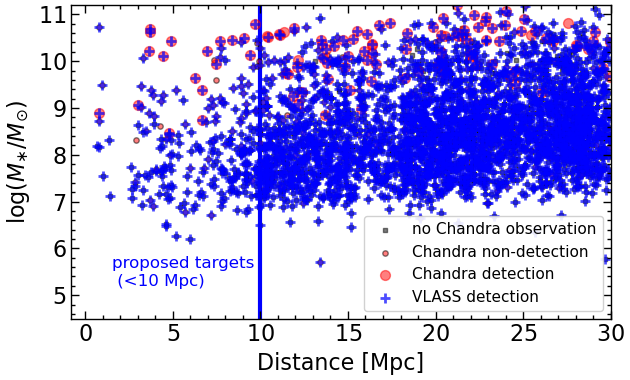

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6.5, 4.0))
ax.scatter(data_50Mpc_targ['bestdist'][(data_50Mpc_targ['chandra_observation'] == 0)],
           data_50Mpc_targ['logmass'][(data_50Mpc_targ['chandra_observation'] == 0)],
           color='k', edgecolors='k', marker='s', s=5, alpha=0.5, label='no Chandra observation', zorder=-1)

ax.scatter(data_50Mpc_targ['bestdist'][(data_50Mpc_targ['chandra_observation'] == 1) & (data_50Mpc_targ['chandra_detection'] == 0)],
           data_50Mpc_targ['logmass'][(data_50Mpc_targ['chandra_observation'] == 1) & (data_50Mpc_targ['chandra_detection'] == 0)],
           color='r', edgecolors='k', s=15, alpha=0.5, label='Chandra non-detection')

ax.scatter(data_50Mpc_targ['bestdist'][data_50Mpc_targ['chandra_detection'] == 1],
           data_50Mpc_targ['logmass'][data_50Mpc_targ['chandra_detection'] == 1],
           color='r', s=50, alpha=0.5, label='Chandra detection')

ax.scatter(data_50Mpc_targ['bestdist'][data_50Mpc_targ['Ftot'] > 2.1],
           data_50Mpc_targ['logmass'][data_50Mpc_targ['Ftot'] > 2.1],
           color='b', s=50, alpha=0.7, marker='+', label='VLASS detection')

ax.axvline(10, zorder=-1, lw=3, color='b')
ax.text(1.5, 5.2, 'proposed targets \n (<10 Mpc)', fontsize=12, color='b', zorder=10)


ax.set_xlabel('Distance [Mpc]')
ax.set_ylabel(r'$\log(M_{\ast}/M_{\odot})$')

ax.set_xlim(None, 30)
ax.set_ylim(4.5, 11.2)

ax.legend(frameon=True, fontsize=11, framealpha=0.9, loc=4)
fig.tight_layout()
fig.savefig('30Mpc.pdf', dpi=300)

In [ ]:
data_50Mpc_targ[data_50Mpc_targ['bestdist']<10]

objname,pgc,nsaid,group_id,ra,dec,ra_nsa,dec_nsa,ra_ned,dec_ned,d25,v_h,v_cmb,v_source,hl_obj,lvg_obj,nsa_obj,sga_obj,t_type,color_type,best_type,a_B_leda,a_g_nsa,EBV_irsa,Bt0_leda,BV_color_leda,B_lum,gi_color_nsa,i_lum_nsa,gr_color_sga,r_lum_sga,BR_color_ned,R_lum_ned,BMag,gi_color,mag_flag,cf3_dist,cf3_dist_error,zind_dist,zind_dist_error,zind_indicator,bestdist,bestdist_error,bestdist_method,bestdist_source,dist_ned_flag,logmass_gi,logmass_gr,logmass_BV,logmass_BR,logmass,logmass_error,logmass_src,chandra_observation,chandra_detection,log_lx,chandra_detection_3arcsec,log_lx_3arcsec,z_dr16,z_gama,W4mag,e_W4mag,logSFR,Ftot,e_Ftot,_log_lr,_log_lr_err,logLIR,logLIR_err
str29,int32,int32,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,str3,float64,float64,float64,float64,float64,str6,str6,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str32,float64,float64,str32,int32,int32,float64,float64,float64,float64,float64,float64,str64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
ESO409-015,388,-1,-1,1.3828905,-28.0983395,nan,nan,1.38273,-28.09818,1.0568175092136585,726.0,451.27,lvg,1.0,1.0,0.0,0.0,9.0,late,late,0.06364,nan,0.0143,15.06,nan,114154309.13143638,nan,nan,nan,nan,0.5763259200000004,63682877.400285006,-14.703730775038311,0.5159531403118044,nan,8.796281200947654,3.932533053962915,8.71,0.5131932,TRGB,8.71,0.513,Karachentsev,1,0,nan,nan,nan,7.591,7.591,0.136,B-R,0.0,0.0,nan,0.0,nan,-1.0,-1.0,-1.0,-1.0,-2.3630570000000004,26.25,-1.0,36.854197826943334,-1.0,35.9699149291048,286.0009190774418
ESO444-078,48029,-1,-1,204.128643,-29.2352641,nan,nan,204.12963,-29.23489,1.3899526312133532,577.0,243.46,lvg,1.0,1.0,0.0,0.0,10.0,late,late,0.19694,nan,0.0454,15.25,nan,41954115.846890785,nan,nan,nan,nan,0.4367383199999999,14909734.194641393,-13.616936432691931,0.3605103786191536,nan,4.270660411332029,4.704382902177569,5.42,0.3193464,TRGB,5.42,0.319,Karachentsev,1,0,nan,nan,nan,6.888,6.888,0.136,B-R,0.0,0.0,nan,0.0,nan,-1.0,-1.0,-1.0,-1.0,-2.976776,26.25,-1.0,36.44216009000478,-1.0,35.35619592910481,110.74641891469824
ESO444-084,48111,-1,-1,204.3342555,-28.0447855,nan,nan,204.33329,-28.045,1.0139113857366795,587.0,325.77,lvg,1.0,1.0,0.0,0.0,10.0,late,late,0.25628,nan,0.0589,14.725,nan,51989285.72837512,nan,nan,nan,nan,-0.1253361599999998,11370495.398576243,-13.84978462694824,-0.26540775055679267,nan,4.411001375869932,4.717984967521658,4.61,0.2716212,TRGB,4.61,0.272,Karachentsev,1,0,nan,nan,nan,6.481,6.481,0.136,B-R,0.0,0.0,nan,0.0,nan,-1.0,-1.0,-1.0,-1.0,-3.3320870000000005,26.25,-1.0,36.30156336770731,-1.0,35.00088492910481,80.11852948002677
ESO472-015,513,-1,-1,1.701747,-24.9447471,nan,nan,1.70144,-24.94489,0.6918309709189364,655.0,390.02,hyp,1.0,0.0,0.0,0.0,-0.4,early,early,0.0731,nan,0.0167,16.147000000000002,nan,38896814.678079575,nan,nan,nan,nan,0.8528067999999998,24537864.14931149,-13.534785094292758,0.8238383073496657,nan,8.350971833071352,3.823930046977777,nan,nan,nan,8.351,3.824,CF3-Z,3,-1,nan,nan,nan,7.319,7.319,0.43,B-R,0.0,0.0,nan,0.0,nan,-1.0,-1.0,9.0649995803833,nan,-2.6005130000000003,26.25,-1.0,36.817638484297206,-1.0,35.73245892910481,nan
ESO473-024,-1,-1,-1,7.84375,-22.76583333,nan,nan,7.84379,-22.76596,1.299398265865112,530.0,869.23,lvg,0.0,1.0,0.0,1.0,10.0,late,late,0.0688,nan,0.0168,nan,nan,43131085.58156434,nan,nan,0.12820323354492125,25090813.905287016,0.2644063999999986,19613402.87560917,-13.64697597298775,0.034387889975536205,nan,7.0351689015692145,3.7396741405331007,9.9,1.973258370245484,TF,9.9,1.973,Karachentsev,1,-1,nan,6.889,nan,6.919,6.889,0.175,g-r,0.0,0.0,nan,0.0,nan,-1.0,-1.0,-1.0,-1.0,-2.9759029999999997,26.25,-1.0,36.96543190612311,-1.0,35.357068929104805,369.48899517400275
ESO483-013,14658,-1,2891,63.171336,-23.1589236,nan,nan,63.17133,-23.15889,1.690440931643264,898.0,968.26,lvg,1.0,1.0,0.0,1

In [ ]:
from astropy.coordinates import Angle

coord_pilot = SkyCoord(data_50Mpc_pilot['ra'], data_50Mpc_pilot['dec'], unit='deg')

# Combine the last few bins with few sources into one group/session
bins = np.arange(0, 16, 2)
bins = np.append(bins, 26)

# NGC3242 ; PNe ; Equatorial ; J2000 ; 10:24:46.1 ; -18:38:32 ; Barycentric ; Optical ; 4.70; N;
data_50Mpc_pilot['group'] = np.digitize(coord_pilot.ra.hour, bins=bins)
data_50Mpc_pilot['Equatorial'] = 'Equatorial'
data_50Mpc_pilot['J2000'] = 'J2000'
data_50Mpc_pilot['RA_J2000'] = np.array([Angle(r*u.deg).to_string(unit=u.hour, sep=':', precision=1) for r in data_50Mpc_pilot['ra']])
data_50Mpc_pilot['DE_J2000'] = np.array([Angle(d*u.deg).to_string(unit=u.degree, sep=':', precision=1) for d in data_50Mpc_pilot['dec']])
data_50Mpc_pilot['Heliocentric'] = 'Barycentric' ## ?? need time
data_50Mpc_pilot['Optical'] = 'Optical'
data_50Mpc_pilot['vel'] = data_50Mpc_pilot['v_h']
data_50Mpc_pilot['Calibrator'] = 'N'
data_50Mpc_pilot['EOL'] = ''


ascii.write(data_50Mpc_pilot, 'vla_targets.csv', format='csv', overwrite=True, delimiter=';', 
    include_names=['objname', 'group', 'J2000', 'Equatorial', 'RA_J2000','DE_J2000', 'Heliocentric', 'Optical', 'vel', 'Calibrator', 'EOL']) 

In [ ]:
# Allocate the session time proportionately
# If you have many sources spread over 24h, break them into smaller chunks, e.g., 4-6hr long, by LST range. This way, some of your sessions will fall into low observing time pressure LSTs.
# https://science.nrao.edu/facilities/vla/docs/manuals/proposal-guide/pst/entering/sessions#section-2
bins = np.arange(0, 16, 2)
bins = np.append(bins, 26)
print(bins)
hist, bins = np.histogram(coord_pilot.ra.hour, bins=bins)
hist_norm = hist/np.sum(hist)
np.sum(80*hist_norm) # sum to 80
print('session time [hrs]:', 80*hist_norm) # break the longer ones > 6 hours into two sessions
# Combine the last ones into a big block

[ 0  2  4  6  8 10 12 14 26]
session time [hrs]: [ 9.71659919  6.47773279  2.59109312  2.91497976  6.15384615 11.33603239
 33.68421053  7.12550607]


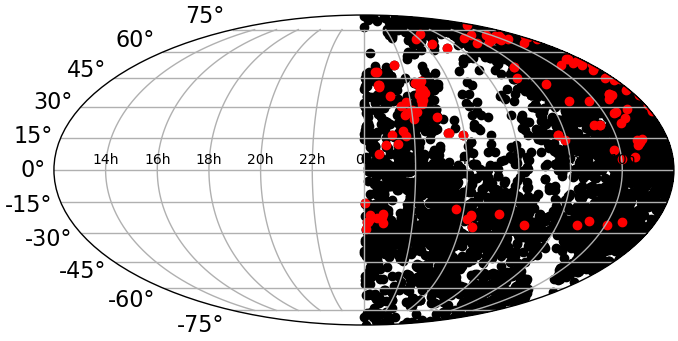

In [ ]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="mollweide")

coord_all = SkyCoord(data_50Mpc['ra'], data_50Mpc['dec'], unit='deg')

ax.scatter(coord_all.ra.radian, coord_all.dec.radian, color='k')

ra = Angle(coord_pilot.ra)
ra = ra.wrap_at(180*u.degree)
dec = Angle(coord_pilot.dec)

ax.scatter(coord_pilot.ra.radian, coord_pilot.dec.radian, color='r')

ax.set_xticklabels(['14h','16h','18h','20h','22h','0h','2h','4h','6h','8h','10h'], fontsize=10)
ax.grid(True)

[ 0  2  4  6  8 10 12 14 16 18 20 22 24]


(array([ 30.,  20.,   8.,   9.,  19.,  35., 104.,  13.,   1.,   2.,   4.,
          2.]),
 array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20., 22., 24.]),
 <BarContainer object of 12 artists>)

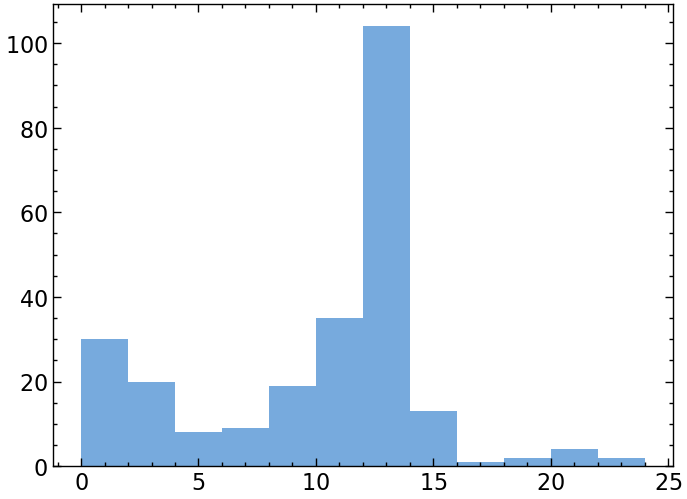

In [ ]:
bins = np.arange(0, 26, 2)
print(bins)
plt.hist(coord_pilot.ra.hour, bins=bins)

In [ ]:
coord_pilot = SkyCoord(data_50Mpc_pilot['ra'], data_50Mpc_pilot['dec'], unit='deg')
coord_pilot

<SkyCoord (ICRS): (ra, dec) in deg
    [(  1.3828905 , -28.0983395 ), (204.128643  , -29.2352641 ),
     (204.3342555 , -28.0447855 ), (  1.701747  , -24.9447471 ),
     (  7.84375   , -22.76583333), ( 63.171336  , -23.1589236 ),
     ( 99.487755  , -26.0001989 ), (132.2749995 , -26.3216054 ),
     (158.846577  , -24.7541149 ), ( 65.0528445 , -21.2433207 ),
     ( 65.3071395 , -21.8458758 ), ( 81.7739085 , -20.6778542 ),
     ( 56.7021255 ,  68.0960926 ), (146.1825    ,   9.6159983 ),
     ( 10.765236  , -22.2475644 ), ( 26.8745535 ,  27.3330062 ),
     (157.097919  ,  68.4120945 ), (190.5629715 ,  38.5027002 ),
     (196.455276  ,  37.6046589 ), (205.076145  , -28.8941873 ),
     (184.6225    ,  28.64583333), (  2.4847695 , -24.963769  ),
     (  3.5165415 , -23.1818333 ), (  3.8547    , -21.4444603 ),
     (  8.3004165 ,  48.5088889 ), (  9.7415835 ,  48.3374306 ),
     ( 10.092075  ,  41.6853283 ), ( 10.6741035 ,  40.8651653 ),
     ( 10.6846845 ,  41.2689778 ), ( 11.7857175 , -20.7

In [ ]:
data_50Mpc_pilot

objname,pgc,nsaid,group_id,ra,dec,ra_nsa,dec_nsa,ra_ned,dec_ned,d25,v_h,v_cmb,v_source,hl_obj,lvg_obj,nsa_obj,sga_obj,t_type,color_type,best_type,a_B_leda,a_g_nsa,EBV_irsa,Bt0_leda,BV_color_leda,B_lum,gi_color_nsa,i_lum_nsa,gr_color_sga,r_lum_sga,BR_color_ned,R_lum_ned,BMag,gi_color,mag_flag,cf3_dist,cf3_dist_error,zind_dist,zind_dist_error,zind_indicator,bestdist,bestdist_error,bestdist_method,bestdist_source,dist_ned_flag,logmass_gi,logmass_gr,logmass_BV,logmass_BR,logmass,logmass_error,logmass_src,chandra_observation,chandra_detection,log_lx,chandra_detection_3arcsec,log_lx_3arcsec,z_dr16,z_gama,W4mag,e_W4mag,logSFR,Ftot,e_Ftot,_log_lr,_log_lr_err,logLIR,logLIR_err,group,Equatorial,J2000,RA_J2000,DE_J2000,Heliocentric,Optical,vel,Calibrator,EOL
str29,int32,int32,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,str3,float64,float64,float64,float64,float64,str6,str6,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str32,float64,float64,str32,int32,int32,float64,float64,float64,float64,float64,float64,str64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,str10,str5,str10,str11,str11,str7,float64,str1,str1
ESO409-015,388,-1,-1,1.3828905,-28.0983395,nan,nan,1.38273,-28.09818,1.0568175092136585,726.0,451.27,lvg,1.0,1.0,0.0,0.0,9.0,late,late,0.06364,nan,0.0143,15.06,nan,114154309.13143638,nan,nan,nan,nan,0.5763259200000004,63682877.400285006,-14.703730775038311,0.5159531403118044,nan,8.796281200947654,3.932533053962915,8.71,0.5131932,TRGB,8.71,0.513,Karachentsev,1,0,nan,nan,nan,7.591,7.591,0.136,B-R,0.0,0.0,nan,0.0,nan,-1.0,-1.0,-1.0,-1.0,-2.3630570000000004,26.25,-1.0,36.854197826943334,-1.0,35.9699149291048,286.0009190774418,1,Equatorial,J2000,0:05:31.9,-28:05:54.0,Barycentric,Optical,726.0,N,
ESO444-078,48029,-1,-1,204.128643,-29.2352641,nan,nan,204.12963,-29.23489,1.3899526312133532,577.0,243.46,lvg,1.0,1.0,0.0,0.0,10.0,late,late,0.19694,nan,0.0454,15.25,nan,41954115.846890785,nan,nan,nan,nan,0.4367383199999999,14909734.194641393,-13.616936432691931,0.3605103786191536,nan,4.270660411332029,4.704382902177569,5.42,0.3193464,TRGB,5.42,0.319,Karachentsev,1,0,nan,nan,nan,6.888,6.888,0.136,B-R,0.0,0.0,nan,0.0,nan,-1.0,-1.0,-1.0,-1.0,-2.976776,26.25,-1.0,36.44216009000478,-1.0,35.35619592910481,110.74641891469824,7,Equatorial,J2000,13:36:30.9,-29:14:07.0,Barycentric,Optical,577.0,N,
ESO444-084,48111,-1,-1,204.3342555,-28.0447855,nan,nan,204.33329,-28.045,1.0139113857366795,587.0,325.77,lvg,1.0,1.0,0.0,0.0,10.0,late,late,0.25628,nan,0.0589,14.725,nan,51989285.72837512,nan,nan,nan,nan,-0.1253361599999998,11370495.398576243,-13.84978462694824,-0.26540775055679267,nan,4.411001375869932,4.717984967521658,4.61,0.2716212,TRGB,4.61,0.272,Karachentsev,1,0,nan,nan,nan,6.481,6.481,0.136,B-R,0.0,0.0,nan,0.0,nan,-1.0,-1.0,-1.0,-1.0,-3.3320870000000005,26.25,-1.0,36.30156336770731,-1.0,35.00088492910481,80.11852948002677,7,Equatorial,J2000,13:37:20.2,-28:02:41.2,Barycentric,Optical,587.0,N,
ESO472-015,513,-1,-1,1.701747,-24.9447471,nan,nan,1.70144,-24.94489,0.6918309709189364,655.0,390.02,hyp,1.0,0.0,0.0,0.0,-0.4,early,early,0.0731,nan,0.0167,16.147000000000002,nan,38896814.678079575,nan,nan,nan,nan,0.8528067999999998,24537864.14931149,-13.534785094292758,0.8238383073496657,nan,8.350971833071352,3.823930046977777,nan,nan,nan,8.351,3.824,CF3-Z,3,-1,nan,nan,nan,7.319,7.319,0.43,B-R,0.0,0.0,nan,0.0,nan,-1.0,-1.0,9.0649995803833,nan,-2.6005130000000003,26.25,-1.0,36.817638484297206,-1.0,35.73245892910481,nan,1,Equatorial,J2000,0:06:48.4,-24:56:41.1,Barycentric,Optical,655.0,N,
ESO473-024,-1,-1,-1,7.84375,-22.76583333,nan,nan,7.84379,-22.76596,1.299398265865112,530.0,869.23,lvg,0.0,1.0,0.0,1.0,10.0,late,late,0.0688,nan,0.0168,nan,nan,43131085.58156434,nan,nan,0.12820323354492125,25090813.905287016,0.2644063999999986,19613402.87560917,-13.